In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split

# Loading labels
Labels from ISIC challenges 2016 - 2024 \
get malignant classifications from all challenges + same amount of benign images

- 2018 test-ground-truth included
- 2018 'MEL', 'AKIEC', 'BCC' are classified as dangerous

#### mal label 2016

In [2]:
# read 2016 files into dataframes
df_16_test = pd.read_csv('../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Test_GroundTruth.csv', header=None, names=['image_id', 'melanoma'])
df_16_train = pd.read_csv('../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv',  header=None, names=['image_id', 'melanoma'])
df_16_test.head()

image_id  melanoma
0  ISIC_0000003       0.0
1  ISIC_0000012       0.0
2  ISIC_0000013       1.0
3  ISIC_0000014       0.0
4  ISIC_0000015       0.0

In [3]:
# extract malignant images
df_16_test_mal = df_16_test.loc[df_16_test['melanoma'] == True, 'image_id']
df_16_train_mal = df_16_train.loc[df_16_train['melanoma'] == 'malignant', 'image_id'] # labels are benign & malignant
len(df_16_test_mal)

75

In [4]:
# combine malignant images from test and training data
df_16_mal = pd.concat([df_16_test_mal, df_16_train_mal], axis=0)
len(df_16_mal)

248

#### mal label 2017

In [5]:
# read 2017 files into dataframes
df_17_test = pd.read_csv('../2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv')
df_17_train = pd.read_csv('../2017/ISIC-2017_Training_Part3_GroundTruth.csv')
df_17_val = pd.read_csv('../2017/ISIC-2017_Validation_Part3_GroundTruth.csv')
df_17_test.head()

image_id  melanoma  seborrheic_keratosis
0  ISIC_0012086       0.0                   1.0
1  ISIC_0012092       0.0                   0.0
2  ISIC_0012095       0.0                   0.0
3  ISIC_0012134       0.0                   1.0
4  ISIC_0012136       0.0                   1.0

In [6]:
# extract malignant images
df_17_test_mal = df_17_test.loc[df_17_test['melanoma'] == True, 'image_id']
df_17_train_mal = df_17_train.loc[df_17_train['melanoma'] == True, 'image_id']
df_17_val_mal = df_17_val.loc[df_17_val['melanoma'] == True, 'image_id']
len(df_17_test_mal)

117

In [7]:
# combine malignant images
df_17_mal = pd.concat([df_17_test_mal, df_17_train_mal, df_17_val_mal], axis=0)
len(df_17_mal)

521

#### mal label 2018
MEL, AKIEC, BCC -> (could become) dangerous

In [8]:
# read 2018 files into dataframes
df_18_test = pd.read_csv('../2018/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv')
df_18_train = pd.read_csv('../2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
df_18_val = pd.read_csv('../2018/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv')
df_18_train.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

In [9]:
# extract malignant images (classify 'MEL', 'BCC' and 'AKIEC' as malignant)
df_18_test_mal = df_18_test.loc[(df_18_test['MEL'] == True) | (df_18_test['BCC'] == True) | (df_18_test['AKIEC'] == True), 'image']
df_18_train_mal = df_18_train.loc[(df_18_train['MEL'] == True) | (df_18_train['BCC'] == True) | (df_18_train['AKIEC'] == True), 'image']
df_18_val_mal = df_18_val.loc[(df_18_val['MEL'] == True) | (df_18_val['BCC'] == True) | (df_18_val['AKIEC'] == True), 'image']
len(df_18_test_mal)

307

In [10]:
# combine malignant images
df_18_mal = pd.concat([df_18_test_mal, df_18_train_mal, df_18_val_mal], axis=0)
len(df_18_mal)

2305

#### mal label 2020

In [11]:
# read 2020 file into dataframe (ground truth only available for training data)
df_20_train = pd.read_csv('../2020/ISIC_2020_Training_GroundTruth.csv') 
df_20_train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [12]:
# extract malignant images
df_20_mal = df_20_train.loc[df_20_train['target'] == True, 'image_name']
len(df_20_mal)

584

#### mal label from 2024 challenge are not used because of the very small imagesizes compared to other years

In [13]:
# -- 2024 contains very small image sizes (127x127 / 4KB) --
df_24 = pd.read_csv('../2024/ISIC_2024_Training_GroundTruth.csv')
df_24['malignant'].sum()

393.0

#### 2016 - 2020 mal

In [14]:
# all names of malignant pictures
df_mal = pd.concat([df_16_mal, df_17_mal, df_18_mal, df_20_mal])
len(df_mal)

3658

## Find duplicated images
Filter by loading binary values of the images and comparing their SHA256-values.

In [16]:
import hashlib
nbHash16=0
nbHash17=0
nbHash18=0
nbHash20=0

def get_image_hash(image_path):
    """Calculates SHA-256 hash of an image."""
    with open(image_path, 'rb') as f:
        img_hash = hashlib.sha256(f.read()).hexdigest()
    return img_hash

def get_filtered_image_hashes(image_dir, valid_names):
    """Calculates hashes of all images in one directory, whose names are contained in valid_names."""
    image_hashes = {}
    counter=0
    global nbHash16
    global nbHash17
    global nbHash18
    global nbHash20
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            base_name = file.split('.')[0]
            if file.endswith(('.png', '.jpg', '.jpeg')) and base_name in valid_names:
                counter+=1
                print("Loading: %s" % counter, end="\r") 
                image_path = os.path.join(root, file)
                img_hash = get_image_hash(image_path)
                if img_hash in image_hashes:
                    image_hashes[img_hash].append(image_path)
                else:
                    image_hashes[img_hash] = [image_path]
                # check, how many pictures are taken out of which dir
                if "2016" in root: 
                    nbHash16+=1
                if "2017" in root: 
                    nbHash17+=1
                if "2018" in root: 
                    nbHash18+=1
                if "2020" in root: 
                    nbHash20+=1
    return image_hashes

# paths to directories
dataset_dirs = [
    '../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Test_Data',
    '../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Training_Data',
    '../2017/ISIC-2017_Test_v2_Data',
    '../2017/ISIC-2017_Training_Data',
    '../2017/ISIC-2017_Validation_Data',
    '../2018/ISIC2018_Task3_Test_Input',
    '../2018/ISIC2018_Task3_Training_Input',
    '../2018/ISIC2018_Task3_Validation_Input',
    '../2020/train'
]

# List of valid names for every dataset (set for faster calculation)
valid_names_lists = [
    set(df_16_test_mal),
    set(df_16_train_mal),
    set(df_17_test_mal),
    set(df_17_train_mal),
    set(df_17_val_mal),
    set(df_18_test_mal),
    set(df_18_train_mal),
    set(df_18_val_mal),
    set(df_20_mal)
]

# calculating hashes for all datasets combining them
all_image_hashes = {}
for dataset_dir, valid_names in zip(dataset_dirs, valid_names_lists):
    dataset_hashes = get_filtered_image_hashes(dataset_dir, valid_names)
    for img_hash, paths in dataset_hashes.items():
        if img_hash in all_image_hashes:
            all_image_hashes[img_hash].extend(paths)
        else:
            all_image_hashes[img_hash] = paths

# Finding duplicates
duplicates = {img_hash: paths for img_hash, paths in all_image_hashes.items() if len(paths) > 1}

print("number of Hashes from: \n2016 {}\n2017 {}\n2018 {}\n2020 {}\n".format(nbHash16, nbHash17, nbHash18, nbHash20))

if duplicates:
    print("{} Duplicates found:".format(len(duplicates.items())))
    for img_hash, paths in duplicates.items():
        print(f"Hash: {img_hash}")
        for path in paths:
            print(f" - {path}")
else:
    print("No duplicates found.")


number of Hashes from: 
2016 248
2017 521
2018 2305
2020 584

211 Duplicates found:
Hash: cc7f9f4c17bd82b1f707cb69f17edc1d4c7b526c7a14a39f2cb3d7404573a803
 - ../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Test_Data/ISIC_0010587.jpg
 - ../2017/ISIC-2017_Training_Data/ISIC_0010587.jpg
Hash: 9b3e854ae5dc3f230b2fea7fefeb3d9572d4e63544ff8bea4d3ce86e28aa6880
 - ../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Test_Data/ISIC_0010034.jpg
 - ../2017/ISIC-2017_Training_Data/ISIC_0010034.jpg
Hash: 98fb30f071a48e4024e5a24bd180511d408c5a6a3b5b56f9fd8901dc68c916c3
 - ../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Test_Data/ISIC_0000420.jpg
 - ../2017/ISIC-2017_Training_Data/ISIC_0000420.jpg
Hash: b533eb5504e709750c238c7c76b2d6cc98fd7c3d27e5163215dcd62128161e41
 - ../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Test_Data/ISIC_0009955.jpg
 - ../2017/ISIC-2017_Training_Data/ISIC_0009955.jpg
Hash: 70b9ef01035f9b5502b6331bf735c2720c8a7c9eb34dc1637514c8076ba76836
 - ../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Test_Data/ISIC_0000393.jpg
 - ../20

In [17]:
# check, in which year duplicates occur
duplIn16 = 0
duplIn17 = 0
duplIn18 = 0
duplIn20 = 0
for hashes, paths in duplicates.items():
    for path in paths:
        if '../2016/' in path: duplIn16 +=1
        if '../2017/' in path: duplIn17 +=1
        if '../2018/' in path: duplIn18 +=1
        if '../2020/' in path: duplIn20 +=1

print("Number of duplicates in \n2016: {}\n2017: {}\n2018: {}\n2020: {}\n".format(duplIn16, duplIn17, duplIn18, duplIn20))

Number of duplicates in 
2016: 209
2017: 207
2018: 0
2020: 6



In [18]:
mal_2016 = []
mal_2017 = []
mal_2018 = []
mal_2020 = []
filtered_mal_paths = []

# erstes aus path duplicates und alle aus nicht duplicates
for img_hash, paths in duplicates.items():
    filtered_mal_paths.append(paths[0])

# make dictionary with not-duplicates
no_duplicates_mal = {img_hash: paths for img_hash, paths in all_image_hashes.items() if len(paths) == 1}
for path in no_duplicates_mal.values():
    filtered_mal_paths.append(path[0])

# use not-duplicanted images for other years
for path in filtered_mal_paths:
    if '../2016/' in path: mal_2016.append(path)
    elif '../2017/' in path: mal_2017.append(path)
    elif '../2018/' in path: mal_2018.append(path)
    elif '../2020/' in path: mal_2020.append(paths[0])

print("Overall number of not-duplicates: {} \nNumber of filtered, malign pictures: {}\n".format(len(no_duplicates_mal), len(filtered_mal_paths)))
print("Number of malign paths from \n2016: {}\n2017: {}\n2018: {}\n2020: {}\n".format(len(mal_2016), len(mal_2017), len(mal_2018), len(mal_2020)))

Overall number of not-duplicates: 3236 
Number of filtered, malign pictures: 3447

Number of malign paths from 
2016: 247
2017: 314
2018: 2305
2020: 581



## Get benign images
The benign images should have an equal distribution from the datasets as the malign images. Under the assumption that all subsets within one year/challenge originated from a single source there should be no systematic difference between these pitures. Thus it should be sufficient to take them from only one of the possible subsets (train/test/validation).

- get paths from bening images
- add same amount from each dataset without duplicates:\
2016: 247\
2017: 314\
2018: 2305\
2020: 581

#### get paths from benign images and filter for duplicates

In [19]:
# get benign images out of every dataset
df_16_train_ben = df_16_train.loc[df_16_train['melanoma'] == 'benign', 'image_id'] # (labels are benign & malignant)
df_17_train_ben = df_17_train.loc[df_17_train['melanoma'] == False, 'image_id']
df_18_train_ben = df_18_train.loc[(df_18_train['NV'] == True) | (df_18_train['BKL'] == True) | (df_18_train['DF'] == True) | (df_18_train['VASC'] == True), 'image']
df_20_ben = df_20_train.loc[df_20_train['target'] == False, 'image_name']

df_ben = pd.concat([df_16_train_ben, df_17_train_ben, df_18_train_ben, df_20_ben])
print("Overall number of benign paths: {}".format(len(df_ben)))

Overall number of benign paths: 42956


In [20]:
nbHash16=0
nbHash17=0
nbHash18=0
nbHash20=0

def get_image_hash(image_path):
    """Calculates SHA-256 hash of an image."""
    with open(image_path, 'rb') as f:
        img_hash = hashlib.sha256(f.read()).hexdigest()
    return img_hash

def get_filtered_image_hashes(image_dir, valid_names):
    """Calculates hashes of all images in one directory, whose names are contained in valid_names."""
    image_hashes = {}
    counter=0
    global nbHash16
    global nbHash17
    global nbHash18
    global nbHash20
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            base_name = file.split('.')[0]
            if file.endswith(('.png', '.jpg', '.jpeg')) and base_name in valid_names:
                counter+=1
                print("Loading: %s" % counter, end="\r") 
                image_path = os.path.join(root, file)
                img_hash = get_image_hash(image_path)
                if img_hash in image_hashes:
                    image_hashes[img_hash].append(image_path)
                else:
                    image_hashes[img_hash] = [image_path]
                # checken, wie viele bilder aus welchen dirs genommen werden
                if "2016" in root: 
                    nbHash16+=1
                if "2017" in root: 
                    nbHash17+=1
                if "2018" in root: 
                    nbHash18+=1
                if "2020" in root: 
                    nbHash20+=1
    return image_hashes

# paths to directories
dataset_dirs = [
    '../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Training_Data',
    '../2017/ISIC-2017_Training_Data',
    '../2018/ISIC2018_Task3_Training_Input',
    '../2020/train'
]

# List of valid names for every dataset
valid_names_lists = [
    set(df_16_train_ben),
    set(df_17_train_ben),
    set(df_18_train_ben),
    set(df_20_ben)
]

# calculating hashes for all datasets combining them
all_image_hashes = {}
for dataset_dir, valid_names in zip(dataset_dirs, valid_names_lists):
    dataset_hashes = get_filtered_image_hashes(dataset_dir, valid_names)
    for img_hash, paths in dataset_hashes.items():
        if img_hash in all_image_hashes:
            all_image_hashes[img_hash].extend(paths)
        else:
            all_image_hashes[img_hash] = paths

# Finding duplicates
duplicates = {img_hash: paths for img_hash, paths in all_image_hashes.items() if len(paths) > 1}

print("number of benign Hashes from: \n2016 {}\n2017 {}\n2018 {}\n2020 {}\n".format(nbHash16, nbHash17, nbHash18, nbHash20))

if duplicates:
    print("{} Duplicates found:".format(len(duplicates.items())))
    for img_hash, paths in duplicates.items():
        print(f"Hash: {img_hash}")
        for path in paths:
            print(f" - {path}")
else:
    print("No duplicates found.")


number of benign Hashes from: 
2016 727
2017 1626
2018 8061
2020 32541

1032 Duplicates found:
Hash: 5fd39f65bde3971aaa9eeb2b4955c38b05c5f3b1a3f9763b215bd0d91cb78264
 - ../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Training_Data/ISIC_0000025.jpg
 - ../2017/ISIC-2017_Training_Data/ISIC_0000025.jpg
Hash: f2dc0dad3864701bf4895c901d712278656502dd15d978e31b7d277509abc093
 - ../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Training_Data/ISIC_0010236.jpg
 - ../2017/ISIC-2017_Training_Data/ISIC_0010236.jpg
Hash: 76357ca069cc9eee899442b3e60d79f6001f5fa9aecac0d90754b2427954d676
 - ../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Training_Data/ISIC_0010222.jpg
 - ../2017/ISIC-2017_Training_Data/ISIC_0010222.jpg
Hash: 53bba2c171235b3c2cada90e76991afa020b766c0b1cacb2f1e8ec2f8f2bb17c
 - ../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Training_Data/ISIC_0006326.jpg
 - ../2017/ISIC-2017_Training_Data/ISIC_0006326.jpg
Hash: cb61806766a1ad9ada52dc2625d5e2bd3e64817760147d23c348b796356dd147
 - ../2016/Hautkrebs/ISBI2016_ISIC_Part3B_Training

#### add same amount from each dataset according to malign, without duplicates

In [21]:
ben_2016 = []
ben_2017 = []
ben_2018 = []
ben_2020 = []

# take only one path from duplicated images
for img_hash, paths in duplicates.items():
    if '../2016/' in paths[0] and len(ben_2016)<247 : ben_2016.append(paths[0])

# make dictionary with not-duplicates
no_duplicates_ben = {img_hash: paths for img_hash, paths in all_image_hashes.items() if len(paths) == 1}

# use not-duplicated images for other years
for img_hash, paths in no_duplicates_ben.items():
    if '../2017/' in paths[0] and len(ben_2017)<314 : ben_2017.append(paths[0])
    elif '../2018/' in paths[0] and len(ben_2018)<2305 : ben_2018.append(paths[0])
    elif '../2020/' in paths[0] and len(ben_2020)<581 : ben_2020.append(paths[0])

# Save all ben paths in one list
filtered_ben_paths = ben_2016 + ben_2017 + ben_2018 + ben_2020

print("Overall number of not-duplicates: {} \nNumber of filtered, benign pictures: {} -> same as malignant".format(len(no_duplicates_ben), len(filtered_ben_paths)))

Overall number of not-duplicates: 40891 
Number of filtered, benign pictures: 3447 -> same as malignant


## Save images and paths

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split

In [ ]:
# ToDo adjust path to resized images
#filtered_ben_paths = ''
#filtered_mal_paths = ''
output_dir_ben='../all_years/resized_jpg/benign'
output_dir_mal='../all_years/resized_jpg/malignant'

In [27]:
def add_padding(image, target_width, target_height):
    # Originale Bildgröße
    h, w = image.shape[:2]
    
    # Berechnung der oberen, unteren, linken und rechten Randgrößen
    top = max((target_height - h) // 2, 0)
    bottom = max(target_height - h - top, 0)
    left = max((target_width - w) // 2, 0)
    right = max(target_width - w - left, 0)

    # Überprüfen, ob die Ränder nicht negativ sind
    if any(x < 0 for x in [top, bottom, left, right]):
        raise ValueError("Die Ränder dürfen nicht negativ sein.")
    
    # Padding anwenden (schwarzer Rand)
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image


def resize_and_normalize_images(image_paths, target_size, output_dir):
    #if not os.path.exists(output_dir):
    #    os.makedirs(output_dir)
    total = len(image_paths)
    current = 0
    
    
    for image_path in image_paths:
        if current%25==0:
            print(f"{current} / {total}", end="\r")
        
        # Bild laden
        image = cv2.imread(image_path)

        # Überprüfen, ob das Bild korrekt geladen wurde
        if image is None:
            raise ValueError("Das Bild konnte nicht geladen werden. Überprüfen Sie den Pfad.")

        # Rand hinzufügen, um auf 6000x4000 zu kommen
        padded_image = add_padding(image, target_width=6000, target_height=4000)
        
        # Bildgröße ändern
        resized_image = cv2.resize(image, target_size)
        
        # Normalisierung (Skalierung auf [0, 1])
        normalized_image = resized_image.astype('float32') / 255.0
        
        normalized_for_saving = (normalized_image * 255).astype('uint8')
        
        # Pfad zum Speichern des Bildes erstellen (falls du sie für spätere Nutzung speichern möchtest)
        base_name = os.path.basename(image_path)
        save_path = os.path.join(output_dir, base_name)
        
        # (-- Save normalized images as .npy or .jpg --)
        #np.save(save_path.replace('.jpg', '.npy'), normalized_for_saving)
        #cv2.imwrite(save_path, normalized_for_saving)

        current+=1


#print("Resize benign Images:")
#resize_and_normalize_images(image_paths=filtered_ben_paths, target_size=(1200, 800), output_dir=output_dir_ben) # -- jpg
print("Resize malign Images:")
resize_and_normalize_images(image_paths=filtered_mal_paths, target_size=(1200, 800), output_dir=output_dir_mal) # -- jpg


Resize malign Images:


In [28]:
# change paths to resized images
filtered_ben_paths_resized = []
filtered_mal_paths_resized = []

for path in filtered_ben_paths: filtered_ben_paths_resized.append(output_dir_ben +'/'+ path.split('/')[-1])
for path in filtered_mal_paths: filtered_mal_paths_resized.append(output_dir_mal +'/'+ path.split('/')[-1])

print('Path to ben: {} \nPath to mal: {}'.format(filtered_ben_paths_resized[0], filtered_mal_paths_resized[0]))

Path to ben: ../all_years/resized_jpg/benign/ISIC_0000025.jpg 
Path to mal: ../all_years/resized_jpg/malignant/ISIC_0010587.jpg


In [ ]:
# save paths as csv
def save_list_to_csv(string_list, file_path):
    df = pd.DataFrame(string_list, columns=["Paths"])
    df.to_csv(file_path, index=False)

path_ben = "../all_years/resized_jpg/paths/benign_jpg.csv"
path_mal = "../all_years/resized_jpg/paths/malignant_jpg.csv"
save_list_to_csv(filtered_ben_paths_resized, path_ben)
save_list_to_csv(filtered_mal_paths_resized, path_mal)

# Split and load images

### Using keras dataset API

- shuffle images
- data augemtation und anpassung
- create 80/20 train and test datasets

In [9]:
# Set Log-Level to only show Errors (0 = Show all, 1 = Info, 2 = Warning, 3 = Error)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

#### load data

In [10]:
# classes are in alphanumerical order. class a=0 --> benign=0 (class b=1 --> malignant=1)
data_train = tf.keras.utils.image_dataset_from_directory('../all_years/resized_jpg', image_size=(600, 400), batch_size=16, seed=42, validation_split=0.1, subset='training') 
test = tf.keras.utils.image_dataset_from_directory('../all_years/resized_jpg', image_size=(600, 400), batch_size=16, seed=42, validation_split=0.1, subset='validation') 

# Make all Dataset-Operations deterministic
options = tf.data.Options()
options.experimental_deterministic = True

Found 6894 files belonging to 2 classes.
Using 6205 files for training.
Found 6894 files belonging to 2 classes.
Using 689 files for validation.


## Preprocess data for VGG16
#### Split Data (train - validation - test)

In [11]:
# Get amount of images to use. Take ca. 80% for training and 20% for validation
train_size=int(len(data_train)*.8)
val_size=int(len(data_train)*.2)+1

train_size+ val_size

388

In [12]:
# Get images
train = data_train.take(train_size)
val = data_train.skip(train_size).take(val_size)
len(val)

78

In [13]:
# (just to check on loaded batches)
test_iterator = test.as_numpy_iterator()
batch = test_iterator.next()
labels = batch[1]
sum(labels)

2024-10-09 16:14:19.754727: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10

In [14]:
def get_images_and_labels(dataset):
    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.extend(img_batch)
        labels.extend(label_batch)
    return np.array(images), np.array(labels)

In [15]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train = train.map(lambda x, y: (preprocess_input(x), y))
val = val.map(lambda x, y: (preprocess_input(x), y))
test = test.map(lambda x, y: (preprocess_input(x), y))

# X_test in function 'calculate_roc_pr' needed
X_test, y_test = get_images_and_labels(test)
print(np.sum(y_test == 1))

345


# Train models

## w_FN_1

### Define custom Loss function

In [2]:
def optimized_custom_loss_FN_1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    w_FP = tf.constant(1.0, dtype=tf.float32)
    w_FN = tf.constant(1.0, dtype=tf.float32)

    # Use of tf.where for conditional calculation
    FP_comp = tf.where(y_true == 0, y_pred, tf.zeros_like(y_pred))
    FN_comp = tf.where(y_true == 1, 1.0 - y_pred, tf.zeros_like(y_pred))

    # Including weights
    FP_comp = w_FP * FP_comp
    FN_comp = w_FN * FN_comp

    # Calculate risk value and return mean value
    risk_tensor = FP_comp + FN_comp
    return tf.reduce_mean(risk_tensor)


### VGG16

In [ ]:
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)

# Load VGG16 without top
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(600, 400, 3))

for layer in base_model.layers:
    layer.trainable = False

# Create model
model_FN_1 = models.Sequential([
    base_model,
    layers.Flatten(), 
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model_FN_1.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001),
              loss=optimized_custom_loss_FN_1, #'binary_crossentropy',
              metrics=['accuracy'])

# Show model
model_FN_1.summary()


### train model

In [16]:
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam

logdir = 'logs_FN_1'
tensorboard_callback = TensorBoard(log_dir=logdir)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,  # Number of epochs after which training will be stopped if there is no improvement 
    verbose=1,  # Display a message when early stopping is applied
    restore_best_weights=True
    )

hist_FN_1 = model_FN_1.fit(train, epochs=60, batch_size=16, validation_data=val, callbacks=[tensorboard_callback, early_stopping])


Epoch 1/60
310/310 [==============================] - 279s 887ms/step - loss: 0.4669 - accuracy: 0.5357 - val_loss: 0.3827 - val_accuracy: 0.6530
Epoch 2/60
310/310 [==============================] - 272s 874ms/step - loss: 0.3819 - accuracy: 0.6220 - val_loss: 0.3274 - val_accuracy: 0.7004
Epoch 3/60
310/310 [==============================] - 271s 871ms/step - loss: 0.3298 - accuracy: 0.6800 - val_loss: 0.3028 - val_accuracy: 0.7181
Epoch 4/60
310/310 [==============================] - 269s 866ms/step - loss: 0.2924 - accuracy: 0.7165 - val_loss: 0.2956 - val_accuracy: 0.7269
Epoch 5/60
310/310 [==============================] - 270s 868ms/step - loss: 0.2752 - accuracy: 0.7302 - val_loss: 0.2806 - val_accuracy: 0.7382
Epoch 6/60
310/310 [==============================] - 270s 867ms/step - loss: 0.2619 - accuracy: 0.7448 - val_loss: 0.2727 - val_accuracy: 0.7422
Epoch 7/60
310/310 [==============================] - 270s 869ms/step - loss: 0.2436 - accuracy: 0.7631 - val_loss: 0.2715 -

### Plot model

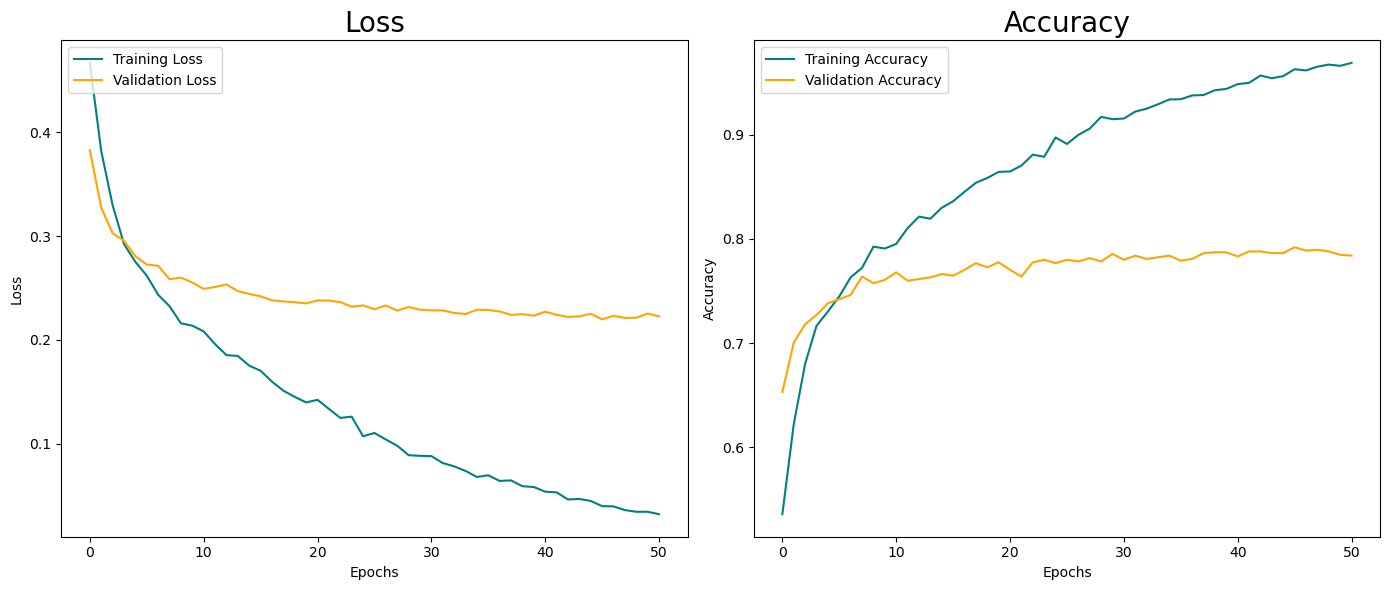

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Loss
ax1.plot(hist_FN_1.history['loss'], color='teal', label='Training Loss')
ax1.plot(hist_FN_1.history['val_loss'], color='orange', label='Validation Loss')
ax1.set_title('Loss', fontsize=20)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# Accuracy
ax2.plot(hist_FN_1.history['accuracy'], color='teal', label='Training Accuracy')
ax2.plot(hist_FN_1.history['val_accuracy'], color='orange', label='Validation Accuracy')
ax2.set_title('Accuracy', fontsize=20)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Evaluation

In [18]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
prec = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_FN_1.predict(X)
    prec.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{prec.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 1s 912ms/step
Precision:0.763005793094635, Recall:0.38260868191719055, Accuracy:0.6313498020172119


## w_FN_2

In [25]:
def optimized_custom_loss_FN_2(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    w_FP = tf.constant(1.0, dtype=tf.float32)
    w_FN = tf.constant(2.0, dtype=tf.float32)

    # Use of tf.where for conditional calculation
    FP_comp = tf.where(y_true == 0, y_pred, tf.zeros_like(y_pred))
    FN_comp = tf.where(y_true == 1, 1.0 - y_pred, tf.zeros_like(y_pred))

    # Including weights
    FP_comp = w_FP * FP_comp
    FN_comp = w_FN * FN_comp

    # Calculate risk value and return mean value
    risk_tensor = FP_comp + FN_comp
    return tf.reduce_mean(risk_tensor)
    

In [25]:
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)

# Create model
model_FN_2 = models.Sequential([
    base_model,
    layers.Flatten(), 
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model_FN_2.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001),
              loss=optimized_custom_loss_FN_2,
              metrics=['accuracy'])

# Show model
model_FN_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 18, 12, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 110592)            0         
                                                                 
 dense_5 (Dense)             (None, 4096)              452988928 
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                                 
 dense_7 (Dense)             (None, 1000)             

In [26]:
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam

logdir = 'logs_FN_2'
tensorboard_callback = TensorBoard(log_dir=logdir)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Display a message when early stopping is applied
    restore_best_weights=True
    )

hist_FN_2 = model_FN_2.fit(train, epochs=60, batch_size=16, validation_data=val, callbacks=[tensorboard_callback, early_stopping])


Epoch 1/60
310/310 [==============================] - 377s 1s/step - loss: 0.5791 - accuracy: 0.5286 - val_loss: 0.4778 - val_accuracy: 0.5197
Epoch 2/60
310/310 [==============================] - 369s 1s/step - loss: 0.4745 - accuracy: 0.5817 - val_loss: 0.4172 - val_accuracy: 0.6120
Epoch 3/60
310/310 [==============================] - 377s 1s/step - loss: 0.4181 - accuracy: 0.6462 - val_loss: 0.3868 - val_accuracy: 0.6755
Epoch 4/60
310/310 [==============================] - 380s 1s/step - loss: 0.3867 - accuracy: 0.6718 - val_loss: 0.3677 - val_accuracy: 0.7068
Epoch 5/60
310/310 [==============================] - 365s 1s/step - loss: 0.3599 - accuracy: 0.7065 - val_loss: 0.3642 - val_accuracy: 0.7197
Epoch 6/60
310/310 [==============================] - 370s 1s/step - loss: 0.3371 - accuracy: 0.7169 - val_loss: 0.3495 - val_accuracy: 0.7213
Epoch 7/60
310/310 [==============================] - 366s 1s/step - loss: 0.3206 - accuracy: 0.7339 - val_loss: 0.3597 - val_accuracy: 0.7181

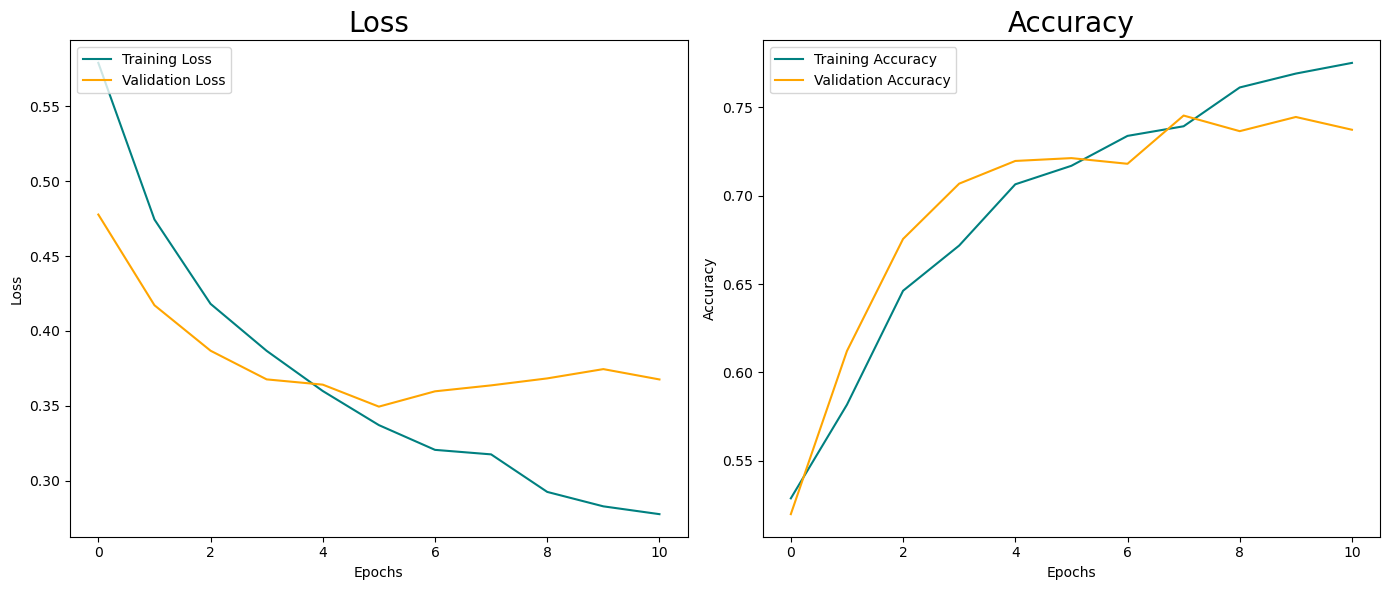

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Loss
ax1.plot(hist_FN_2.history['loss'], color='teal', label='Training Loss')
ax1.plot(hist_FN_2.history['val_loss'], color='orange', label='Validation Loss')
ax1.set_title('Loss', fontsize=20)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# Accuracy
ax2.plot(hist_FN_2.history['accuracy'], color='teal', label='Training Accuracy')
ax2.plot(hist_FN_2.history['val_accuracy'], color='orange', label='Validation Accuracy')
ax2.set_title('Accuracy', fontsize=20)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
prec = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_FN_2.predict(X)
    prec.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{prec.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 95ms/step
Precision:0.6794871687889099, Recall:0.6144927740097046, Accuracy:0.6618287563323975


## w_FN * 4

In [36]:
def optimized_custom_loss_FN_4(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    w_FP = tf.constant(1.0, dtype=tf.float32)
    w_FN = tf.constant(4.0, dtype=tf.float32)

    # Use of tf.where for conditional calculation
    FP_comp = tf.where(y_true == 0, y_pred, tf.zeros_like(y_pred))
    FN_comp = tf.where(y_true == 1, 1.0 - y_pred, tf.zeros_like(y_pred))

    # Including weights
    FP_comp = w_FP * FP_comp
    FN_comp = w_FN * FN_comp

    # Calculate risk value and return mean value
    risk_tensor = FP_comp + FN_comp
    return tf.reduce_mean(risk_tensor)


In [32]:
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)

# Create model
model_FN_4 = models.Sequential([
    base_model,
    layers.Flatten(), 
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model_FN_4.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001),
              loss=optimized_custom_loss_FN_4,
              metrics=['accuracy'])

# Show model
model_FN_4.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 18, 12, 512)       14714688  
                                                                 
 flatten_2 (Flatten)         (None, 110592)            0         
                                                                 
 dense_10 (Dense)            (None, 4096)              452988928 
                                                                 
 dropout_6 (Dropout)         (None, 4096)              0         
                                                                 
 dense_11 (Dense)            (None, 4096)              16781312  
                                                                 
 dropout_7 (Dropout)         (None, 4096)              0         
                                                                 
 dense_12 (Dense)            (None, 1000)             

In [33]:
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam

logdir = 'logs_FN_4'
tensorboard_callback = TensorBoard(log_dir=logdir)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Display a message when early stopping is applied
    restore_best_weights=True
    )

hist_FN_4 = model_FN_4.fit(train, epochs=60, batch_size=16, validation_data=val, callbacks=[tensorboard_callback, early_stopping])


Epoch 1/60
310/310 [==============================] - 417s 1s/step - loss: 0.6803 - accuracy: 0.5036 - val_loss: 0.4992 - val_accuracy: 0.5028
Epoch 2/60
310/310 [==============================] - 419s 1s/step - loss: 0.5130 - accuracy: 0.5212 - val_loss: 0.4885 - val_accuracy: 0.5165
Epoch 3/60
310/310 [==============================] - 419s 1s/step - loss: 0.5049 - accuracy: 0.5597 - val_loss: 0.4684 - val_accuracy: 0.5847
Epoch 4/60
310/310 [==============================] - 425s 1s/step - loss: 0.4717 - accuracy: 0.6294 - val_loss: 0.4704 - val_accuracy: 0.6635
Epoch 5/60
310/310 [==============================] - 422s 1s/step - loss: 0.4376 - accuracy: 0.6599 - val_loss: 0.4555 - val_accuracy: 0.6819
Epoch 6/60
310/310 [==============================] - 421s 1s/step - loss: 0.4053 - accuracy: 0.6833 - val_loss: 0.4817 - val_accuracy: 0.6980
Epoch 7/60
310/310 [==============================] - 419s 1s/step - loss: 0.3996 - accuracy: 0.6998 - val_loss: 0.4987 - val_accuracy: 0.7149

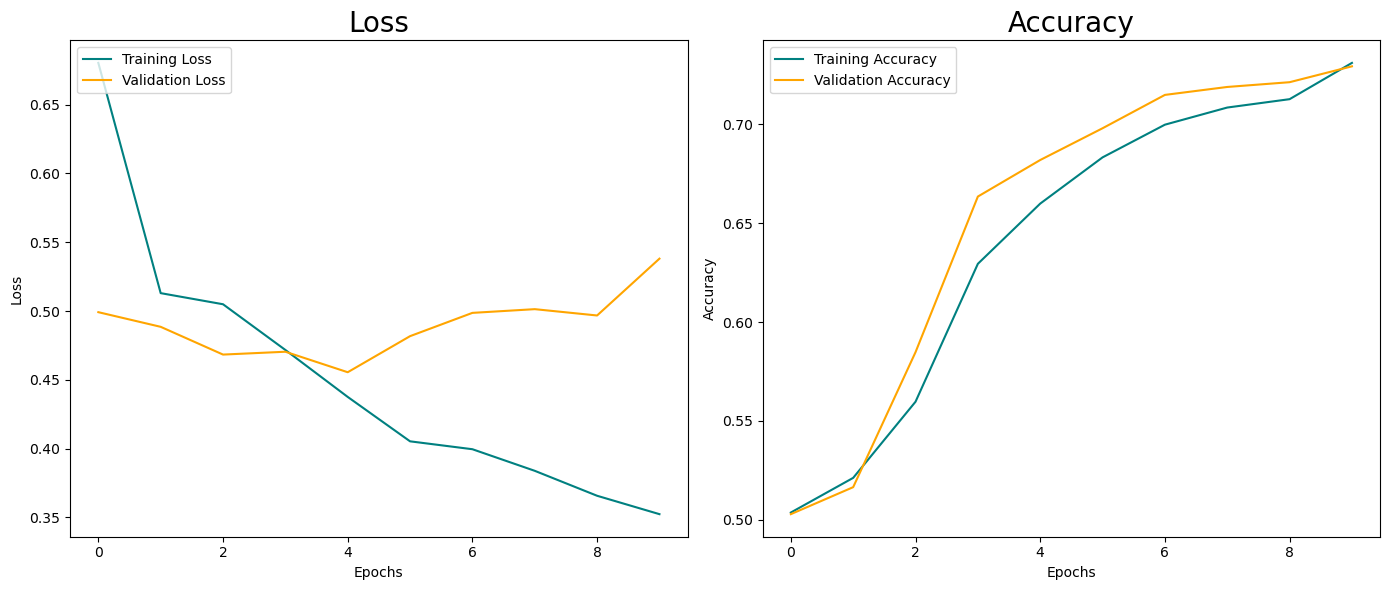

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Loss
ax1.plot(hist_FN_4.history['loss'], color='teal', label='Training Loss')
ax1.plot(hist_FN_4.history['val_loss'], color='orange', label='Validation Loss')
ax1.set_title('Loss', fontsize=20)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# Accuracy
ax2.plot(hist_FN_4.history['accuracy'], color='teal', label='Training Accuracy')
ax2.plot(hist_FN_4.history['val_accuracy'], color='orange', label='Validation Accuracy')
ax2.set_title('Accuracy', fontsize=20)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
prec = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_FN_4.predict(X)
    prec.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{prec.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 138ms/step
Precision:0.5925233364105225, Recall:0.9188405871391296, Accuracy:0.642960786819458


## w_FN * 8

In [42]:
def optimized_custom_loss_FN_8(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    w_FP = tf.constant(1.0, dtype=tf.float32)
    w_FN = tf.constant(8.0, dtype=tf.float32)

    # Use of tf.where for conditional calculation
    FP_comp = tf.where(y_true == 0, y_pred, tf.zeros_like(y_pred))
    FN_comp = tf.where(y_true == 1, 1.0 - y_pred, tf.zeros_like(y_pred))

    # Including weights
    FP_comp = w_FP * FP_comp
    FN_comp = w_FN * FN_comp

    # Calculate risk value and return mean value
    risk_tensor = FP_comp + FN_comp
    return tf.reduce_mean(risk_tensor)
    

In [ ]:
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)

# Create model
model_FN_8 = models.Sequential([
    base_model,
    layers.Flatten(), 
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model_FN_8.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001),
              loss=optimized_custom_loss_FN_8,
              metrics=['accuracy'])

# Show model
model_FN_8.summary()


In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam

logdir = 'logs_FN_8'
tensorboard_callback = TensorBoard(log_dir=logdir)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Display a message when early stopping is applied
    restore_best_weights=True
    )

hist_FN_8 = model_FN_8.fit(train, epochs=60, batch_size=16, validation_data=val, callbacks=[tensorboard_callback, early_stopping])


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Loss
ax1.plot(hist_FN_8.history['loss'], color='teal', label='Training Loss')
ax1.plot(hist_FN_8.history['val_loss'], color='orange', label='Validation Loss')
ax1.set_title('Loss', fontsize=20)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# Accuracy
ax2.plot(hist_FN_8.history['accuracy'], color='teal', label='Training Accuracy')
ax2.plot(hist_FN_8.history['val_accuracy'], color='orange', label='Validation Accuracy')
ax2.set_title('Accuracy', fontsize=20)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
prec = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_FN_8.predict(X)
    prec.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{prec.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')

## w_FN_16

In [45]:
def optimized_custom_loss_FN_16(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    w_FP = tf.constant(1.0, dtype=tf.float32)
    w_FN = tf.constant(16.0, dtype=tf.float32)

    # Use of tf.where for conditional calculation
    FP_comp = tf.where(y_true == 0, y_pred, tf.zeros_like(y_pred))
    FN_comp = tf.where(y_true == 1, 1.0 - y_pred, tf.zeros_like(y_pred))

    # Including weights
    FP_comp = w_FP * FP_comp
    FN_comp = w_FN * FN_comp

    # Calculate risk value and return mean value
    risk_tensor = FP_comp + FN_comp
    return tf.reduce_mean(risk_tensor)


In [19]:
#seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)

# Create model
model_FN_16 = models.Sequential([
    base_model,
    layers.Flatten(), 
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model_FN_16.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001),
              loss=optimized_custom_loss_FN_16,
              metrics=['accuracy'])

# Show model
model_FN_16.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 18, 12, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 110592)            0         
                                                                 
 dense_5 (Dense)             (None, 4096)              452988928 
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                                 
 dense_7 (Dense)             (None, 1000)             

In [20]:
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam

logdir = 'logs_FN_16'
tensorboard_callback = TensorBoard(log_dir=logdir)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Display a message when early stopping is applied
    restore_best_weights=True
    )

hist_FN_16 = model_FN_16.fit(train, epochs=60, batch_size=16, validation_data=val, callbacks=[tensorboard_callback, early_stopping])


Epoch 1/60
310/310 [==============================] - 317s 1s/step - loss: 0.9040 - accuracy: 0.5046 - val_loss: 0.4998 - val_accuracy: 0.5012
Epoch 2/60
310/310 [==============================] - 311s 1s/step - loss: 0.5016 - accuracy: 0.4984 - val_loss: 0.4981 - val_accuracy: 0.5020
Epoch 3/60
310/310 [==============================] - 305s 984ms/step - loss: 0.5041 - accuracy: 0.5058 - val_loss: 0.4989 - val_accuracy: 0.5012
Epoch 4/60
310/310 [==============================] - 305s 982ms/step - loss: 0.5054 - accuracy: 0.5208 - val_loss: 0.4994 - val_accuracy: 0.5004
Epoch 5/60
310/310 [==============================] - 305s 983ms/step - loss: 0.5123 - accuracy: 0.5315 - val_loss: 0.4973 - val_accuracy: 0.4996
Epoch 6/60
310/310 [==============================] - 306s 985ms/step - loss: 0.5503 - accuracy: 0.5480 - val_loss: 0.4828 - val_accuracy: 0.5133
Epoch 7/60
310/310 [==============================] - 305s 984ms/step - loss: 0.5243 - accuracy: 0.5552 - val_loss: 0.4856 - val_a

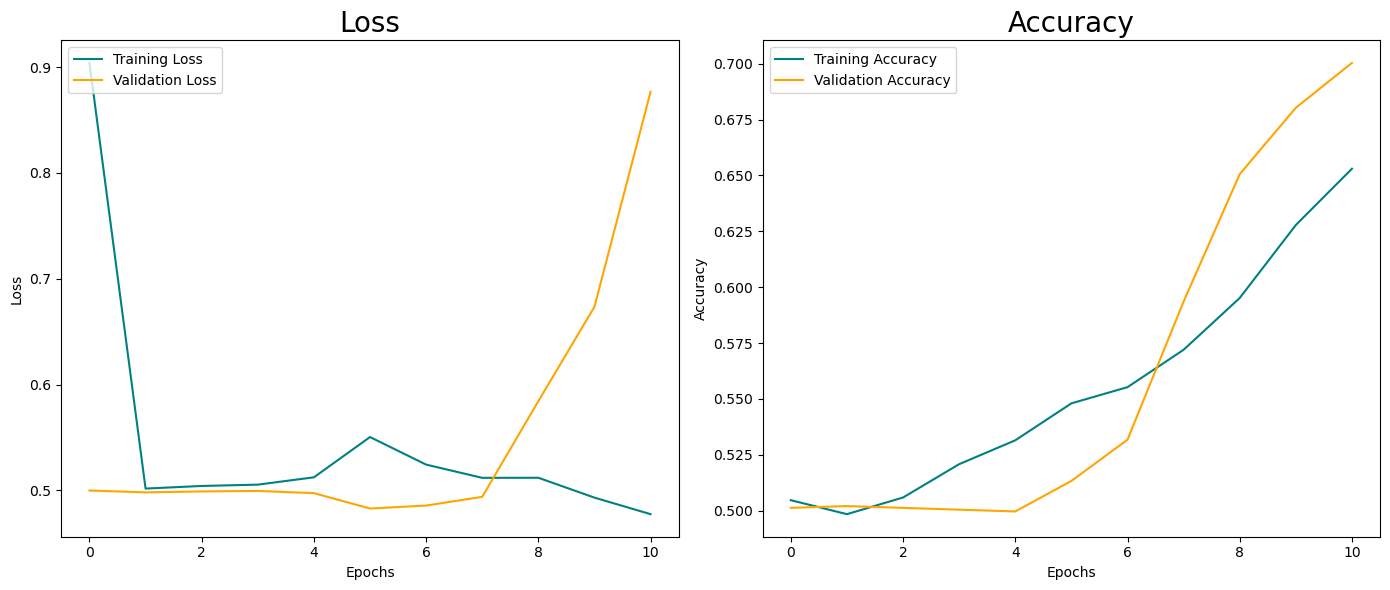

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Loss
ax1.plot(hist_FN_16.history['loss'], color='teal', label='Training Loss')
ax1.plot(hist_FN_16.history['val_loss'], color='orange', label='Validation Loss')
ax1.set_title('Loss', fontsize=20)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# Accuracy
ax2.plot(hist_FN_16.history['accuracy'], color='teal', label='Training Accuracy')
ax2.plot(hist_FN_16.history['val_accuracy'], color='orange', label='Validation Accuracy')
ax2.set_title('Accuracy', fontsize=20)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
prec = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_FN_16.predict(X)
    prec.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{prec.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 1s 1s/step
Precision:0.5029154419898987, Recall:1.0, Accuracy:0.5050798058509827


# Auswertung

## Load saved models

In [2]:
def optimized_custom_loss_FN_1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    w_FP = tf.constant(1.0, dtype=tf.float32)
    w_FN = tf.constant(1.0, dtype=tf.float32)

    # Use of tf.where for conditional calculation
    FP_comp = tf.where(y_true == 0, y_pred, tf.zeros_like(y_pred))
    FN_comp = tf.where(y_true == 1, 1.0 - y_pred, tf.zeros_like(y_pred))

    # Including weights
    FP_comp = w_FP * FP_comp
    FN_comp = w_FN * FN_comp

    # Calculate risk value and return mean value
    risk_tensor = FP_comp + FN_comp
    return tf.reduce_mean(risk_tensor)

# load and compile saved model
model_FN_1 = tf.keras.models.load_model('../models/model_FN_1_02.h5', custom_objects={'optimized_custom_loss_FN_1': optimized_custom_loss_FN_1})
model_FN_1.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001),
              loss=optimized_custom_loss_FN_1,
              metrics=['accuracy'])

#model_FN_1.summary()

Metal device set to: Apple M2 Max


2024-10-09 16:09:16.593595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-09 16:09:16.593940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def optimized_custom_loss_FN_2(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    w_FP = tf.constant(1.0, dtype=tf.float32)
    w_FN = tf.constant(2.0, dtype=tf.float32)

    # Use of tf.where for conditional calculation
    FP_comp = tf.where(y_true == 0, y_pred, tf.zeros_like(y_pred))
    FN_comp = tf.where(y_true == 1, 1.0 - y_pred, tf.zeros_like(y_pred))

    # Including weights
    FP_comp = w_FP * FP_comp
    FN_comp = w_FN * FN_comp

    # Calculate risk value and return mean value
    risk_tensor = FP_comp + FN_comp
    return tf.reduce_mean(risk_tensor)

# load and compile saved model
model_FN_2 = tf.keras.models.load_model('../models/model_FN_2_02.h5', custom_objects={'optimized_custom_loss': optimized_custom_loss_FN_2})
model_FN_2.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001),
              loss=optimized_custom_loss_FN_2,
              metrics=['accuracy'])

#model_FN_2.summary()

In [4]:
def optimized_custom_loss_FN_4(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    w_FP = tf.constant(1.0, dtype=tf.float32)
    w_FN = tf.constant(4.0, dtype=tf.float32)

    # Use of tf.where for conditional calculation
    FP_comp = tf.where(y_true == 0, y_pred, tf.zeros_like(y_pred))
    FN_comp = tf.where(y_true == 1, 1.0 - y_pred, tf.zeros_like(y_pred))

    # Including weights
    FP_comp = w_FP * FP_comp
    FN_comp = w_FN * FN_comp

    # Calculate risk value and return mean value
    risk_tensor = FP_comp + FN_comp
    return tf.reduce_mean(risk_tensor)

# load and compile saved model
model_FN_4 = tf.keras.models.load_model('../models/model_FN_4_02.h5', custom_objects={'optimized_custom_loss': optimized_custom_loss_FN_4})
model_FN_4.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001),
              loss=optimized_custom_loss_FN_4,
              metrics=['accuracy'])

#model_FN_4.summary()

In [5]:
def optimized_custom_loss_FN_8(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    w_FP = tf.constant(1.0, dtype=tf.float32)
    w_FN = tf.constant(8.0, dtype=tf.float32)

    # Use of tf.where for conditional calculation
    FP_comp = tf.where(y_true == 0, y_pred, tf.zeros_like(y_pred))
    FN_comp = tf.where(y_true == 1, 1.0 - y_pred, tf.zeros_like(y_pred))

    # Including weights
    FP_comp = w_FP * FP_comp
    FN_comp = w_FN * FN_comp

    # Calculate risk value and return mean value
    risk_tensor = FP_comp + FN_comp
    return tf.reduce_mean(risk_tensor)

# load and compile saved model
model_FN_8 = tf.keras.models.load_model('../models/model_FN_8_02.h5', custom_objects={'optimized_custom_loss': optimized_custom_loss_FN_8})
model_FN_8.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001),
              loss=optimized_custom_loss_FN_8,
              metrics=['accuracy'])

#model_FN_8.summary()

In [6]:
def optimized_custom_loss_FN_16(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    w_FP = tf.constant(1.0, dtype=tf.float32)
    w_FN = tf.constant(16.0, dtype=tf.float32)

    # Use of tf.where for conditional calculation
    FP_comp = tf.where(y_true == 0, y_pred, tf.zeros_like(y_pred))
    FN_comp = tf.where(y_true == 1, 1.0 - y_pred, tf.zeros_like(y_pred))

    # Including weights
    FP_comp = w_FP * FP_comp
    FN_comp = w_FN * FN_comp

    # Calculate risk value and return mean value
    risk_tensor = FP_comp + FN_comp
    return tf.reduce_mean(risk_tensor)

# load and compile saved model
model_FN_16 = tf.keras.models.load_model('../models/model_FN_16_02.h5', custom_objects={'optimized_custom_loss': optimized_custom_loss_FN_16})
model_FN_16.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.000001),
              loss=optimized_custom_loss_FN_16,
              metrics=['accuracy'])

#model_FN_16.summary()

In [51]:
# !! nötig???

from sklearn.metrics import roc_curve, auc, confusion_matrix

def get_images_and_labels(dataset):
    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.extend(img_batch)
        labels.extend(label_batch)
    return np.array(images), np.array(labels)

def calculate_roc_pr(model, given_threshold=None, plot=None, give_all=None, ax=None, FN_ratio=None):
    """Calculates ROC-curve, auc, TPR and FPR for the optimal
    or a specific threshold for a given model. Can plot the ROC curve. 
    Can give all calculated parameters back, to plot a ROC curve"""

    # (plot == None -> plot)
    if ax is None:
        ax = plt.gca()
        
    y_pred_prob = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Calculation of the Youden index to find the optimum point
    youden_index = tpr - fpr
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    # Convert predictions into classes based on the optimal threshold value
    y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
    
    # Calculate confusion matrix based on the optimal predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()
    optimal_fpr = fp / (fp + tn)
    optimal_fnr = fn / (fn + tp)


    if given_threshold == None:        
        if plot == None:
            # Output the optimum threshold
            print(f"Optimaler Schwellenwert: {optimal_threshold}")
            print(f"True Positive Rate am optimalen Punkt: {optimal_tpr}")
            print(f"False Positive Rate am optimalen Punkt: {optimal_fpr}")

            # Plot ROC-Curve
            plt.figure(figsize=(8, 6)) # auch ax?
            ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Kurve FN_{FN_ratio}: (area = {roc_auc:.3f})')
            ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            # Optimal point
            ax.scatter(optimal_fpr, optimal_tpr, color='red', marker='o', label=f'Optimaler Punkt (Thresh={optimal_threshold:.4f})')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title('Receiver Operating Characteristic (ROC) Curve')
            ax.legend(loc='lower right')
            ax.grid()
    
            return optimal_threshold, optimal_fpr, optimal_fnr
            
        else:
            return fpr, tpr, roc_auc, optimal_fpr, optimal_tpr

    else:
        # Find the index of the threshold that is closest to the given value
        closest_threshold_idx = np.argmin(np.abs(thresholds - given_threshold))
        closest_threshold = thresholds[closest_threshold_idx]
        closest_tpr = tpr[closest_threshold_idx]

        # Convert predictions into classes based on the optimal threshold value
        y_pred_optimal = (y_pred_prob >= given_threshold).astype(int)
        
        # Calculate confusion matrix based on the optimal predictions
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()
        closest_fpr = fp / (fp + tn)
        closest_fnr = fn / (fn + tp)

        if plot == None:
            # Output of the next threshold value and the associated FPR/TPR
            print(f"Nächstgelegener Schwellenwert: {closest_threshold}")
            print(f"True Positive Rate am nächsten Schwellenwert: {closest_tpr}")
            print(f"False Positive Rate am nächsten Schwellenwert: {closest_fpr}")
    
            # Plot ROC-Curve
            plt.figure(figsize=(8, 6))
            ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Kurve FN_{FN_ratio}: (area = {roc_auc:.2f})')
            ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            # Optimal point
            ax.scatter(optimal_fpr, optimal_tpr, color='blue', marker='x', s=80, label=f'Optimaler Punkt (Thresh={optimal_threshold:.4f})')
            # Closest threshold
            ax.scatter(closest_fpr, closest_tpr, color='red', marker='o', label=f'Optimaler Threshold für FN_1 (Thresh={closest_threshold:.4f})')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title('Receiver Operating Characteristic (ROC) Curve')
            ax.legend(loc='lower right')
            ax.grid()

            return optimal_threshold, optimal_fpr, optimal_fnr, closest_fpr, closest_fnr
            
        else:
            return closest_threshold, closest_fpr, closest_tpr, closest_fnr
        

## Minimal ER & Threshs for all ratios

In [19]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

def thresh_and_ER_for_all_ratios(model):
    """Calculates ER_min for all ratios and belonging fpr, tpr and threshold"""

    y_pred_prob = model.predict(X_test)
    
    w_FP = 1
    w_FN = 1
    p = np.sum(y_test == 1)
    n = np.sum(y_test == 0)
    c_FN = (w_FN * p) / (w_FP * n)

    # get all threshs
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    ratios = [1, 2, 4, 8, 16]
    fpr_ER_min = []
    tpr_ER_min = []
    ER_min = []
    opt_thresh = []
    
    for ratio in ratios:
        
        all_ER = []
        # get fnr for thresh
        for threshold in thresholds:
            # Convert predictions into classes based on threshold value
            y_pred_thresh = (y_pred_prob >= threshold).astype(int)
            
            # Calculate confusion matrix based on the optimal predictions
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
            fpr_thresh = fp / (fp + tn)
            fnr_thresh = fn / (fn + tp)
    
            # Calculate ER with given ratio for all threshs 
            ER = fpr_thresh + c_FN * ratio * fnr_thresh
            all_ER.append(ER)
    
        idx_ER_min = all_ER.index(min(all_ER))    

        fpr_ER_min.append(fpr[idx_ER_min])
        tpr_ER_min.append(tpr[idx_ER_min])
        ER_min.append(all_ER[idx_ER_min])
        opt_thresh.append(thresholds[idx_ER_min])

    return fpr_ER_min, tpr_ER_min, ER_min, opt_thresh


In [20]:
# calculate all minimal fpr, tpr, ER and threshs for all ratios
FN_1_fpr_ER_min, FN_1_tpr_ER_min, FN_1_ER_all, FN_1_ER_thresh_all = thresh_and_ER_for_all_ratios(model_FN_1)
FN_2_fpr_ER_min, FN_2_tpr_ER_min, FN_2_ER_all, FN_2_ER_thresh_all = thresh_and_ER_for_all_ratios(model_FN_2)
FN_4_fpr_ER_min, FN_4_tpr_ER_min, FN_4_ER_all, FN_4_ER_thresh_all = thresh_and_ER_for_all_ratios(model_FN_4)
FN_8_fpr_ER_min, FN_8_tpr_ER_min, FN_8_ER_all, FN_8_ER_thresh_all = thresh_and_ER_for_all_ratios(model_FN_8)
FN_16_fpr_ER_min, FN_16_tpr_ER_min, FN_16_ER_all, FN_16_ER_thresh_all = thresh_and_ER_for_all_ratios(model_FN_16)


22/22 [==============================] - 22s 1s/step


In [21]:
# print all minimal ER for every ratio
print('ER for FN_1 and c_FN = 1 is: {:.2f} with thresh: {:.3f}'.format(FN_1_ER_all[0], FN_1_ER_thresh_all[0]))
print('ER for FN_1 and c_FN = 2 is: {:.2f} with thresh: {:.3f}'.format(FN_1_ER_all[1], FN_1_ER_thresh_all[1]))
print('ER for FN_1 and c_FN = 4 is: {:.2f} with thresh: {:.3f}'.format(FN_1_ER_all[2], FN_1_ER_thresh_all[2]))
print('ER for FN_1 and c_FN = 8 is: {:.2f} with thresh: {:.3f}'.format(FN_1_ER_all[3], FN_1_ER_thresh_all[3]))
print('ER for FN_1 and c_FN = 16 is: {:.2f} with thresh: {:.4f}\n'.format(FN_1_ER_all[4], FN_1_ER_thresh_all[4]))

print('ER for FN_2 and c_FN = 1 is: {:.2f} with thresh: {:.3f}'.format(FN_2_ER_all[0], FN_2_ER_thresh_all[0]))
print('ER for FN_2 and c_FN = 2 is: {:.2f} with thresh: {:.3f}'.format(FN_2_ER_all[1], FN_2_ER_thresh_all[1]))
print('ER for FN_2 and c_FN = 4 is: {:.2f} with thresh: {:.3f}'.format(FN_2_ER_all[2], FN_2_ER_thresh_all[2]))
print('ER for FN_2 and c_FN = 8 is: {:.2f} with thresh: {:.3f}'.format(FN_2_ER_all[3], FN_2_ER_thresh_all[3]))
print('ER for FN_2 and c_FN = 16 is: {:.2f} with thresh: {:.4f}\n'.format(FN_2_ER_all[4], FN_2_ER_thresh_all[4]))

print('ER for FN_4 and c_FN = 1 is: {:.2f} with thresh: {:.3f}'.format(FN_4_ER_all[0], FN_4_ER_thresh_all[0]))
print('ER for FN_4 and c_FN = 2 is: {:.2f} with thresh: {:.3f}'.format(FN_4_ER_all[1], FN_4_ER_thresh_all[1]))
print('ER for FN_4 and c_FN = 4 is: {:.2f} with thresh: {:.3f}'.format(FN_4_ER_all[2], FN_4_ER_thresh_all[2]))
print('ER for FN_4 and c_FN = 8 is: {:.2f} with thresh: {:.3f}'.format(FN_4_ER_all[3], FN_4_ER_thresh_all[3]))
print('ER for FN_4 and c_FN = 16 is: {:.2f} with thresh: {:.4f}\n'.format(FN_4_ER_all[4], FN_4_ER_thresh_all[4]))

print('ER for FN_8 and c_FN = 1 is: {:.2f} with thresh: {:.3f}'.format(FN_8_ER_all[0], FN_8_ER_thresh_all[0]))
print('ER for FN_8 and c_FN = 2 is: {:.2f} with thresh: {:.3f}'.format(FN_8_ER_all[1], FN_8_ER_thresh_all[1]))
print('ER for FN_8 and c_FN = 4 is: {:.2f} with thresh: {:.3f}'.format(FN_8_ER_all[2], FN_8_ER_thresh_all[2]))
print('ER for FN_8 and c_FN = 8 is: {:.2f} with thresh: {:.3f}'.format(FN_8_ER_all[3], FN_8_ER_thresh_all[3]))
print('ER for FN_8 and c_FN = 16 is: {:.2f} with thresh: {:.4f}\n'.format(FN_8_ER_all[4], FN_8_ER_thresh_all[4]))

print('ER for FN_16 and c_FN = 1 is: {:.2f} with thresh: {:.3f}'.format(FN_16_ER_all[0], FN_16_ER_thresh_all[0]))
print('ER for FN_16 and c_FN = 2 is: {:.2f} with thresh: {:.3f}'.format(FN_16_ER_all[1], FN_16_ER_thresh_all[1]))
print('ER for FN_16 and c_FN = 4 is: {:.2f} with thresh: {:.3f}'.format(FN_16_ER_all[2], FN_16_ER_thresh_all[2]))
print('ER for FN_16 and c_FN = 8 is: {:.2f} with thresh: {:.3f}'.format(FN_16_ER_all[3], FN_16_ER_thresh_all[3]))
print('ER for FN_16 and c_FN = 16 is: {:.2f} with thresh: {:.4f}'.format(FN_16_ER_all[4], FN_16_ER_thresh_all[4]))


ER for FN_1 and c_FN = 1 is: 0.44 with thresh: 0.286
ER for FN_1 and c_FN = 2 is: 0.54 with thresh: 0.125
ER for FN_1 and c_FN = 4 is: 0.66 with thresh: 0.038
ER for FN_1 and c_FN = 8 is: 0.81 with thresh: 0.005
ER for FN_1 and c_FN = 16 is: 0.94 with thresh: 0.0001

ER for FN_2 and c_FN = 1 is: 0.54 with thresh: 0.506
ER for FN_2 and c_FN = 2 is: 0.63 with thresh: 0.199
ER for FN_2 and c_FN = 4 is: 0.69 with thresh: 0.061
ER for FN_2 and c_FN = 8 is: 0.82 with thresh: 0.061
ER for FN_2 and c_FN = 16 is: 0.96 with thresh: 0.0001

ER for FN_4 and c_FN = 1 is: 0.56 with thresh: 0.932
ER for FN_4 and c_FN = 2 is: 0.67 with thresh: 0.524
ER for FN_4 and c_FN = 4 is: 0.75 with thresh: 0.192
ER for FN_4 and c_FN = 8 is: 0.83 with thresh: 0.192
ER for FN_4 and c_FN = 16 is: 0.93 with thresh: 0.0020

ER for FN_8 and c_FN = 1 is: 0.59 with thresh: 0.991
ER for FN_8 and c_FN = 2 is: 0.68 with thresh: 0.941
ER for FN_8 and c_FN = 4 is: 0.75 with thresh: 0.910
ER for FN_8 and c_FN = 8 is: 0.84 wit

## Plot with WBA & Bezier

#### Save all roc curves

In [22]:
# get ROC 
def pred_roc(model):
    y_pred_prob = model.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

In [23]:
# get roc predictions (verified)
fpr_FN_1, tpr_FN_1, auc_FN_1 = pred_roc(model_FN_1)
fpr_FN_2, tpr_FN_2, auc_FN_2 = pred_roc(model_FN_2)
fpr_FN_4, tpr_FN_4, auc_FN_4 = pred_roc(model_FN_4)
fpr_FN_8, tpr_FN_8, auc_FN_8 = pred_roc(model_FN_8)
fpr_FN_16, tpr_FN_16, auc_FN_16 = pred_roc(model_FN_16)

22/22 [==============================] - 24s 1s/step


In [24]:
from scipy.special import comb
import matplotlib.lines as mlines

# Auxiliary function for calculating Bézier curve points
def bezier_curve(points, n_points=100):
    n = len(points) - 1
    t = np.linspace(0, 1, n_points)
    curve = np.zeros((n_points, 2))
    for i in range(n + 1):
        curve += np.outer(comb(n, i) * (1 - t)**(n - i) * t**i, points[i])
    return curve

def roc_with_wba(fpr, tpr, roc_auc, w_TP_wba, w_TN_wba, #roc & background
                 fpr_BA, tpr_BA, thresh_BA, #BA fpr_BA & tpr_BA corresponds to ER_1 or balanced weighting
                 fpr_ER_min, tpr_ER_min, thresh_ER_min, # ER_min
                 wba_ratio=None, ax=None, bezier=None, model_number=None, 
                 cross=True, color_curve='black', color_point='black'): # to compare ROCs
    
    if ax is None:
        ax = plt.gca()

    legend_handles=[]
    # Creating a grid for TPR (y-axis) and FPR (x-axis)
    fpr_wba = np.linspace(0, 1, 500)  # False Positive Rate
    tpr_wba = np.linspace(0, 1, 500)  # True Positive Rate
    FPR_wba, TPR_wba = np.meshgrid(fpr_wba, tpr_wba)
    
    TNR_wba = 1 - FPR_wba
    wba = (w_TN_wba * TPR_wba) + (w_TP_wba * TNR_wba) # !!! TN_wba and TP_wba have been swapped !!!
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.contourf(FPR_wba, TPR_wba, wba, levels=np.linspace(0, 1, 1000), cmap='plasma', alpha=0.1) # Color gradient
    contour = ax.contour(FPR_wba, TPR_wba, wba, levels=np.arange(0.1, 1, 0.1), colors='black', linestyles='--') # Isocontours
    contour_proxy = mlines.Line2D([], [], color='black', linestyle='--', label='WBA with FP/FN = 1/{}'.format(wba_ratio))
    legend_handles.append(contour_proxy)
    roc_curve = ax.plot(fpr, tpr, color=color_curve, lw=2, label=f'ROC Kurve FN_{model_number} (area = {roc_auc:.2f})', zorder=1)
    legend_handles.append(roc_curve[0])
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    if bezier is True:
        bez_fpr = fpr[::4]
        bez_tpr = tpr[::4]
        bez_fpr = np.append(bez_fpr, fpr[-1])
        bez_tpr = np.append(bez_tpr, tpr[-1])
        points = np.column_stack([bez_fpr, bez_tpr])
        bezier_points = bezier_curve(points, n_points=100)
        bezier = ax.plot(bezier_points[:, 0], bezier_points[:, 1], linestyle='-', color='black', label='Bézier-Kurve')
        legend_handles.append(bezier[0])

    # to plot thresh with balanced accuracy
    point_BA = ax.scatter(fpr_BA, tpr_BA, color=color_point, marker='v', s=50, label=f'Ohne Gewichtung (Thresh={thresh_BA:.4f})', zorder=3) # Optimal point
    legend_handles.append(point_BA)
    # plot point with minimal risk for given weight
    if cross==True:
        point_ER_min_out = ax.scatter(fpr_ER_min, tpr_ER_min, color='black', marker='o', s=190, zorder=4)
        point_ER_min_mid = ax.scatter(fpr_ER_min, tpr_ER_min, color='white', marker='o', s=90, zorder=4)
        point_ER_min = ax.scatter(fpr_ER_min, tpr_ER_min, color=color_point, marker='o', s=50, label=f'Optimaler Threshold für FN_{model_number} (Thresh={thresh_ER_min:.4f})', zorder=4) # Nächstgelegene Schwellenwerte
        legend_handles.append(point_ER_min)
    ax.clabel(contour, fmt='%1.1f', inline=True, fontsize=12)
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.set_ylabel('True Positive Rate', fontsize=18)
    ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    ax.legend(loc='lower right', handles=legend_handles, fontsize=16)
    ax.grid()
    

In [25]:
# for multiple curves --> values processed in arrays

from scipy.special import comb
import matplotlib.lines as mlines

# Auxiliary function for calculating Bézier curve points
def bezier_curve(points, n_points=100):
    n = len(points) - 1
    t = np.linspace(0, 1, n_points)
    curve = np.zeros((n_points, 2))
    for i in range(n + 1):
        curve += np.outer(comb(n, i) * (1 - t)**(n - i) * t**i, points[i])
    return curve

def roc_with_wba_multipe(fpr, tpr, roc_auc, w_TP_wba, w_TN_wba, #roc & background
                 fpr_BA, tpr_BA, thresh_BA, #BA
                 fpr_ER_min, tpr_ER_min, thresh_ER_min, # ER_min
                 wba_ratio=None, ax=None, bezier=True, model_number=None, 
                 cross=True):
    
    if ax is None:
        ax = plt.gca()

    curve_colours=['orange', 'cornflowerblue', 'mediumorchid']
    point_colours= ['darkorange', 'royalblue', 'purple']
    legend_handles=[]
    # Creating a grid for TPR (y-axis) and FPR (x-axis)
    fpr_wba = np.linspace(0, 1, 500)  # False Positive Rate
    tpr_wba = np.linspace(0, 1, 500)  # True Positive Rate
    FPR_wba, TPR_wba = np.meshgrid(fpr_wba, tpr_wba)
    
    TNR_wba = 1 - FPR_wba
    wba = (w_TN_wba * TPR_wba) + (w_TP_wba * TNR_wba) # !!! TN_wba and TP_wba have been swapped !!!
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.contourf(FPR_wba, TPR_wba, wba, levels=np.linspace(0, 1, 1000), cmap='plasma', alpha=0.1) # Color gradient
    contour = ax.contour(FPR_wba, TPR_wba, wba, levels=np.arange(0.1, 1, 0.1), colors='black', linestyles='--') # Isocontours
    contour_proxy = mlines.Line2D([], [], color='black', linestyle='--', label='WBA with FP/FN = 1/{}'.format(wba_ratio))
    legend_handles.append(contour_proxy)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    c=-1
    for curves in fpr:
        c+=1
        roc_curve = ax.plot(fpr[c], tpr[c], color=curve_colours[c], lw=2, label=f'ROC Kurve FN_{model_number[c]} (area = {roc_auc[c]:.2f})', zorder=1)
        legend_handles.append(roc_curve[0])

        #if bezier is True:
        bez_fpr = fpr[c][::4]
        bez_tpr = tpr[c][::4]
        bez_fpr = np.append(bez_fpr, fpr[c][-1])
        bez_tpr = np.append(bez_tpr, tpr[c][-1])
        points = np.column_stack([bez_fpr, bez_tpr])
        bezier_points = bezier_curve(points, n_points=100)
        bezier = ax.plot(bezier_points[:, 0], bezier_points[:, 1], linestyle='-', color='black', label='Bézier-Kurve')
        if c==0:
            legend_handles.append(bezier[0])

        # to plot thresh with balanced accuracy
        point_BA = ax.scatter(fpr_BA[c], tpr_BA[c], color=point_colours[c], marker='v', s=50, label=f'FN_{model_number[c]} ohne Gewichtung; (Thresh={thresh_BA[c]:.4f})', zorder=3) # Optimaler Punkt
        legend_handles.append(point_BA)
        # plot point with minimal risk for given weight
        if cross==True:
            point_ER_min_out = ax.scatter(fpr_ER_min[c], tpr_ER_min[c], color='black', marker='o', s=190, zorder=4)
            point_ER_min_mid = ax.scatter(fpr_ER_min[c], tpr_ER_min[c], color='white', marker='o', s=90, zorder=4)#, label=f'Optimaler Threshold für FN_{model_number[c]} (Thresh={thresh_ER_min[c]:.4f})') # Nächstgelegene Schwellenwerte
            point_ER_min = ax.scatter(fpr_ER_min[c], tpr_ER_min[c], color=point_colours[c], marker='o', s=50, label=f'Optimaler Threshold für FN_{model_number[c]} (Thresh={thresh_ER_min[c]:.4f})', zorder=4) # Nächstgelegene Schwellenwerte
            legend_handles.append(point_ER_min)
    ax.clabel(contour, fmt='%1.1f', inline=True, fontsize=12)
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.set_ylabel('True Positive Rate', fontsize=18)
    ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    ax.legend(loc='lower right', handles=legend_handles, fontsize=14)
    ax.grid()
    

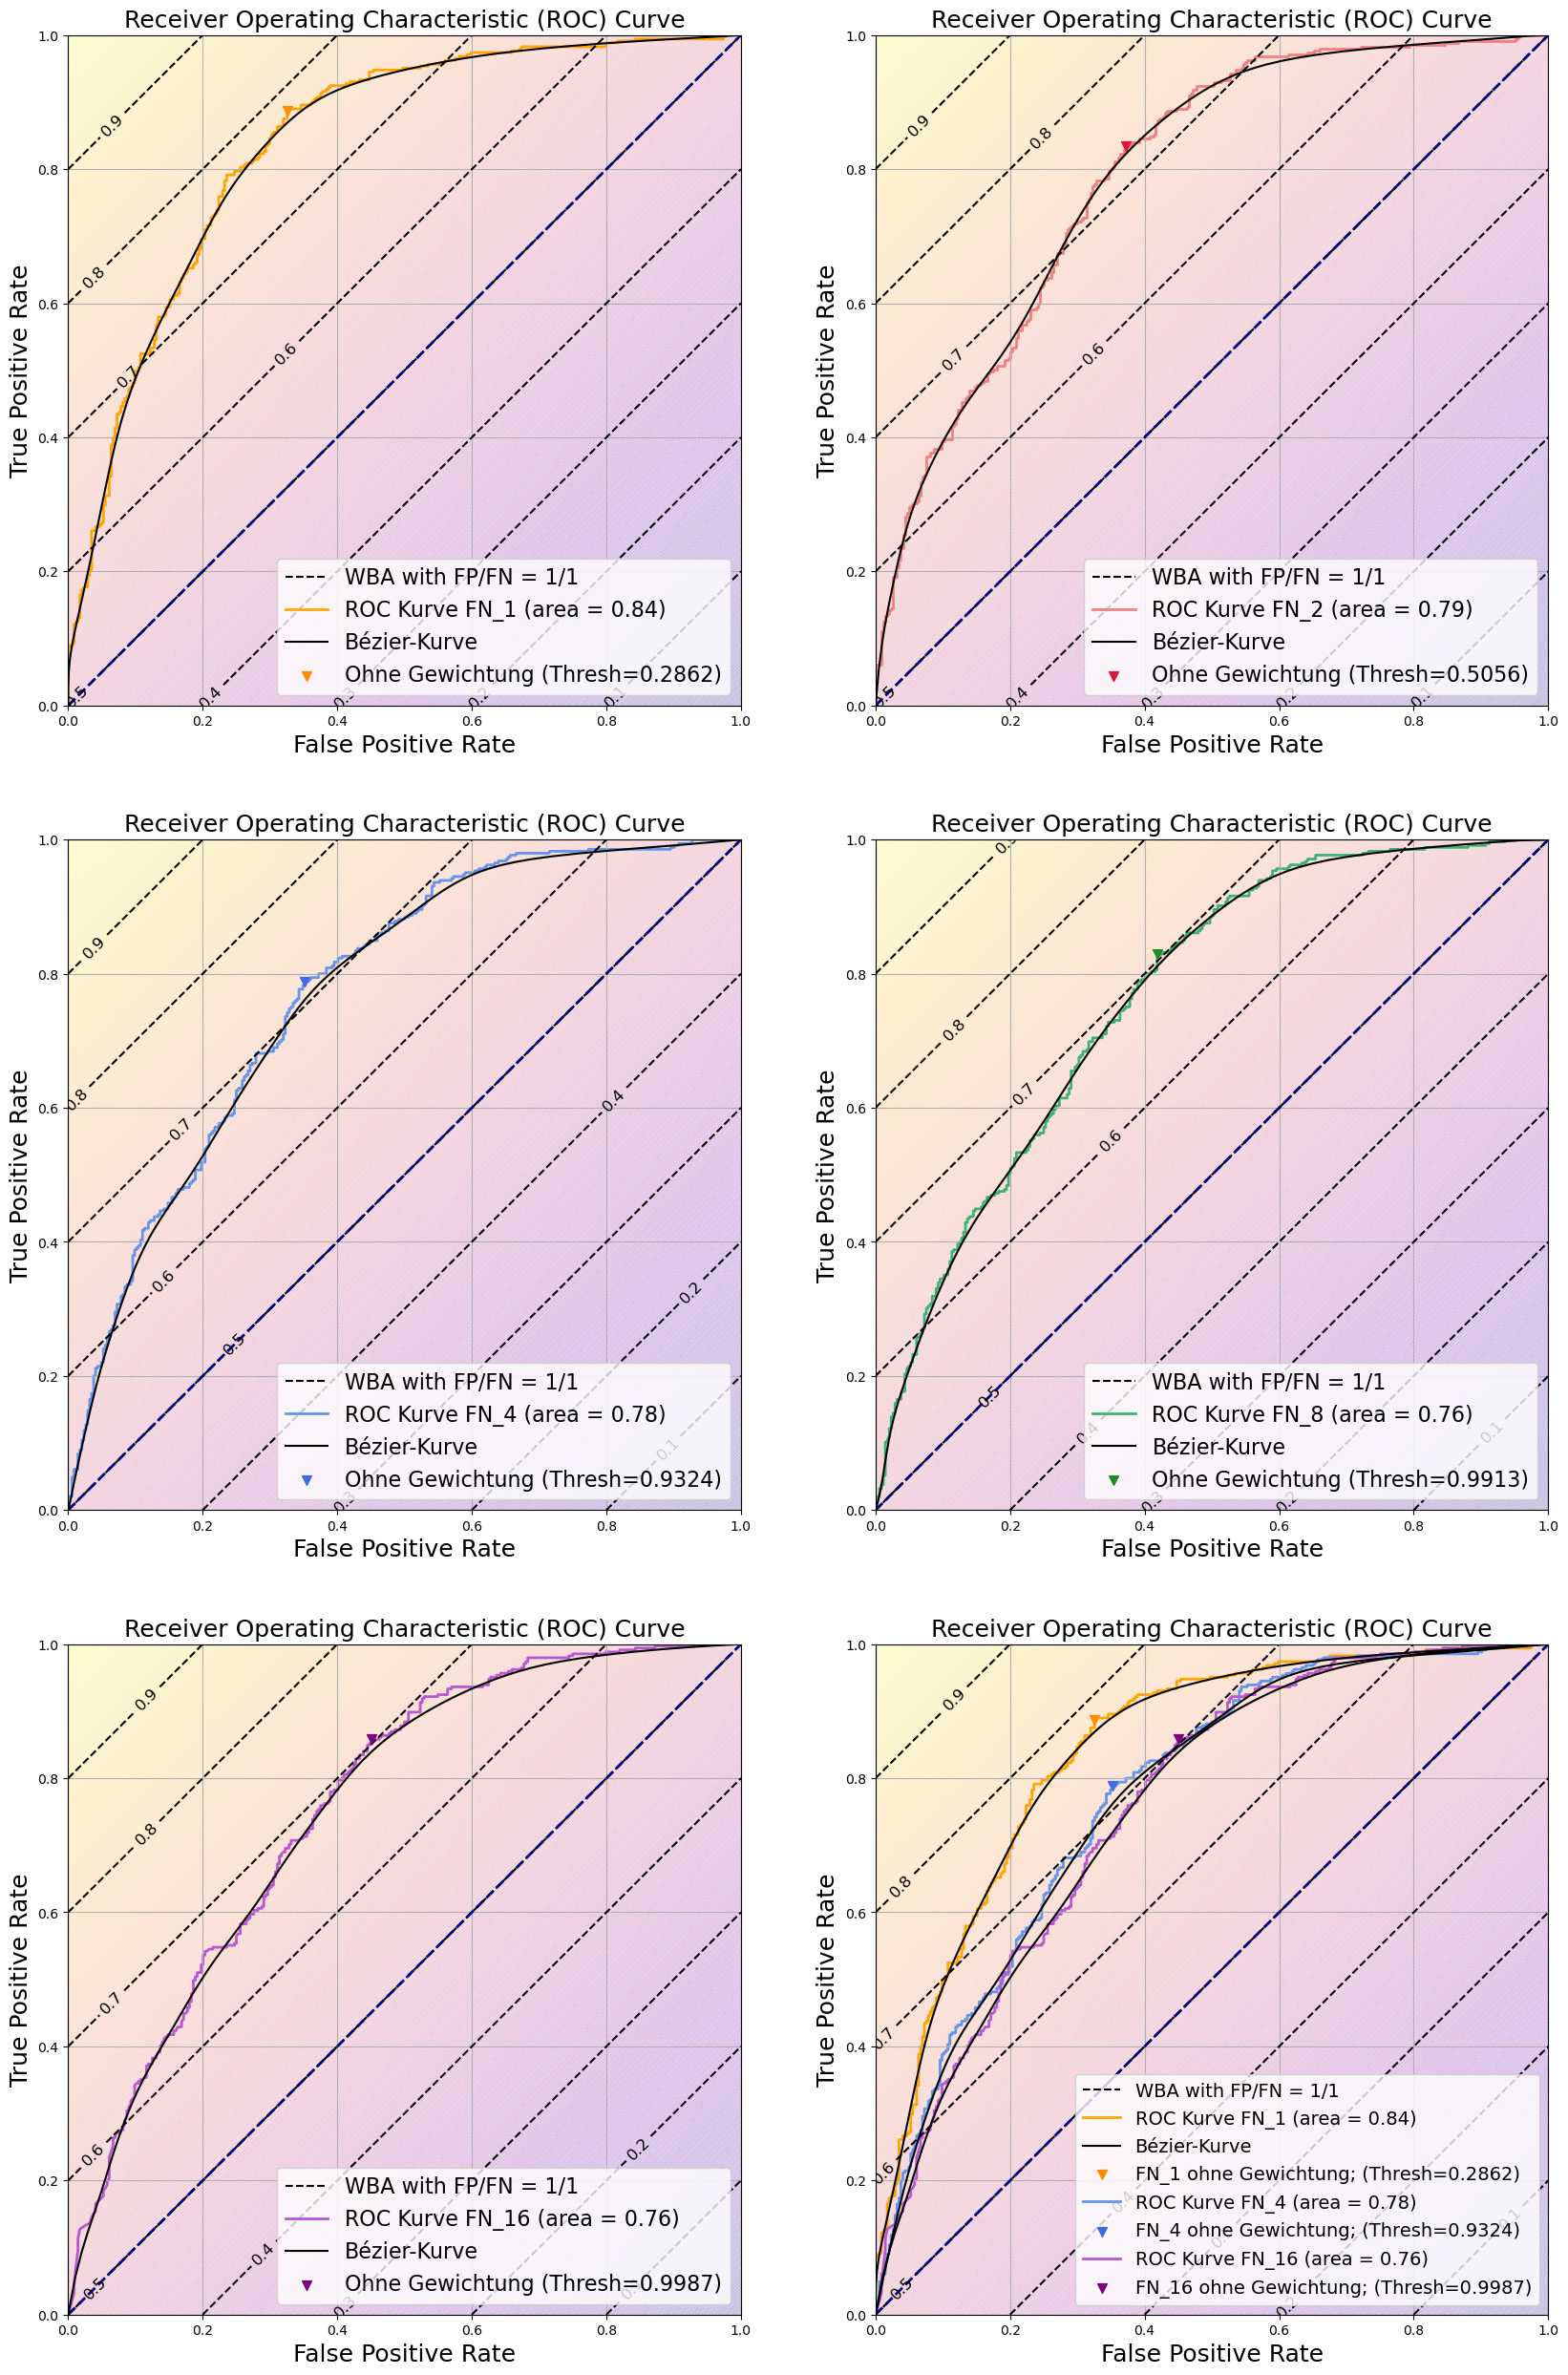

In [26]:
w_TP_wba = 1/2
w_TN_wba = 1/2
fig, sub = plt.subplots(3, 2, figsize=(20, 31))
roc_with_wba(fpr_FN_1, tpr_FN_1, auc_FN_1, w_TP_wba, w_TN_wba, 
             FN_1_fpr_ER_min[0], FN_1_tpr_ER_min[0], FN_1_ER_thresh_all[0], 
             FN_1_fpr_ER_min[0], FN_1_tpr_ER_min[0], FN_1_ER_thresh_all[0], 
             wba_ratio=1, ax=sub[0,0], bezier=True, model_number=1, cross=False, color_curve='orange', color_point='darkorange')

roc_with_wba(fpr_FN_2, tpr_FN_2, auc_FN_2, w_TP_wba, w_TN_wba, 
             FN_2_fpr_ER_min[0], FN_2_tpr_ER_min[0], FN_2_ER_thresh_all[0], 
             FN_2_fpr_ER_min[0], FN_2_tpr_ER_min[0], FN_2_ER_thresh_all[0], 
             wba_ratio=1, ax=sub[0,1], bezier=True, model_number=2, cross=False, color_curve='lightcoral', color_point='crimson')

roc_with_wba(fpr_FN_4, tpr_FN_4, auc_FN_4, w_TP_wba, w_TN_wba, 
             FN_4_fpr_ER_min[0], FN_4_tpr_ER_min[0], FN_4_ER_thresh_all[0], 
             FN_4_fpr_ER_min[0], FN_4_tpr_ER_min[0], FN_4_ER_thresh_all[0], 
             wba_ratio=1, ax=sub[1,0], bezier=True, model_number=4, cross=False, color_curve='cornflowerblue', color_point='royalblue')

roc_with_wba(fpr_FN_8, tpr_FN_8, auc_FN_8, w_TP_wba, w_TN_wba, 
             FN_8_fpr_ER_min[0], FN_8_tpr_ER_min[0], FN_8_ER_thresh_all[0], 
             FN_8_fpr_ER_min[0], FN_8_tpr_ER_min[0], FN_8_ER_thresh_all[0], 
             wba_ratio=1, ax=sub[1,1], bezier=True, model_number=8, cross=False, color_curve='mediumseagreen', color_point='forestgreen')

roc_with_wba(fpr_FN_16, tpr_FN_16, auc_FN_16, w_TP_wba, w_TN_wba, 
             FN_16_fpr_ER_min[0], FN_16_tpr_ER_min[0], FN_16_ER_thresh_all[0], 
             FN_16_fpr_ER_min[0], FN_16_tpr_ER_min[0], FN_16_ER_thresh_all[0], 
             wba_ratio=1, ax=sub[2,0], bezier=True, model_number=16, cross=False, color_curve='mediumorchid', color_point='purple')


# combined plot 1, 4, 16
fpr_FN_1_4 = [fpr_FN_1, fpr_FN_4, fpr_FN_16]
tpr_FN_1_4 = [tpr_FN_1, tpr_FN_4, tpr_FN_16]
auc_FN_1_4 = [auc_FN_1, auc_FN_4, auc_FN_16]
FN_1_4_fpr_ER_min = [FN_1_fpr_ER_min[0], FN_4_fpr_ER_min[0], FN_16_fpr_ER_min[0]]
FN_1_4_tpr_ER_min = [FN_1_tpr_ER_min[0],  FN_4_tpr_ER_min[0], FN_16_tpr_ER_min[0]]
FN_1_4_ER_thresh_all = [FN_1_ER_thresh_all[0], FN_4_ER_thresh_all[0], FN_16_ER_thresh_all[0]]
FN_1_4_fpr_ER_min = [FN_1_fpr_ER_min[0], FN_4_fpr_ER_min[0], FN_16_fpr_ER_min[0]]
FN_1_4_tpr_ER_min = [FN_1_tpr_ER_min[0], FN_4_tpr_ER_min[0], FN_16_tpr_ER_min[0]]
FN_1_4_ER_thresh_all = [FN_1_ER_thresh_all[0], FN_4_ER_thresh_all[0], FN_16_ER_thresh_all[0]]
model_numbers = [1,4,16]


roc_with_wba_multipe(fpr_FN_1_4, tpr_FN_1_4, auc_FN_1_4, w_TP_wba, w_TN_wba, 
             FN_1_4_fpr_ER_min, FN_1_4_tpr_ER_min, FN_1_4_ER_thresh_all, 
             FN_1_4_fpr_ER_min, FN_1_4_tpr_ER_min, FN_1_4_ER_thresh_all, 
             wba_ratio=1, ax=sub[2,1], model_number=model_numbers, cross=False)


In [421]:
fig.savefig('comparison_wba_1')

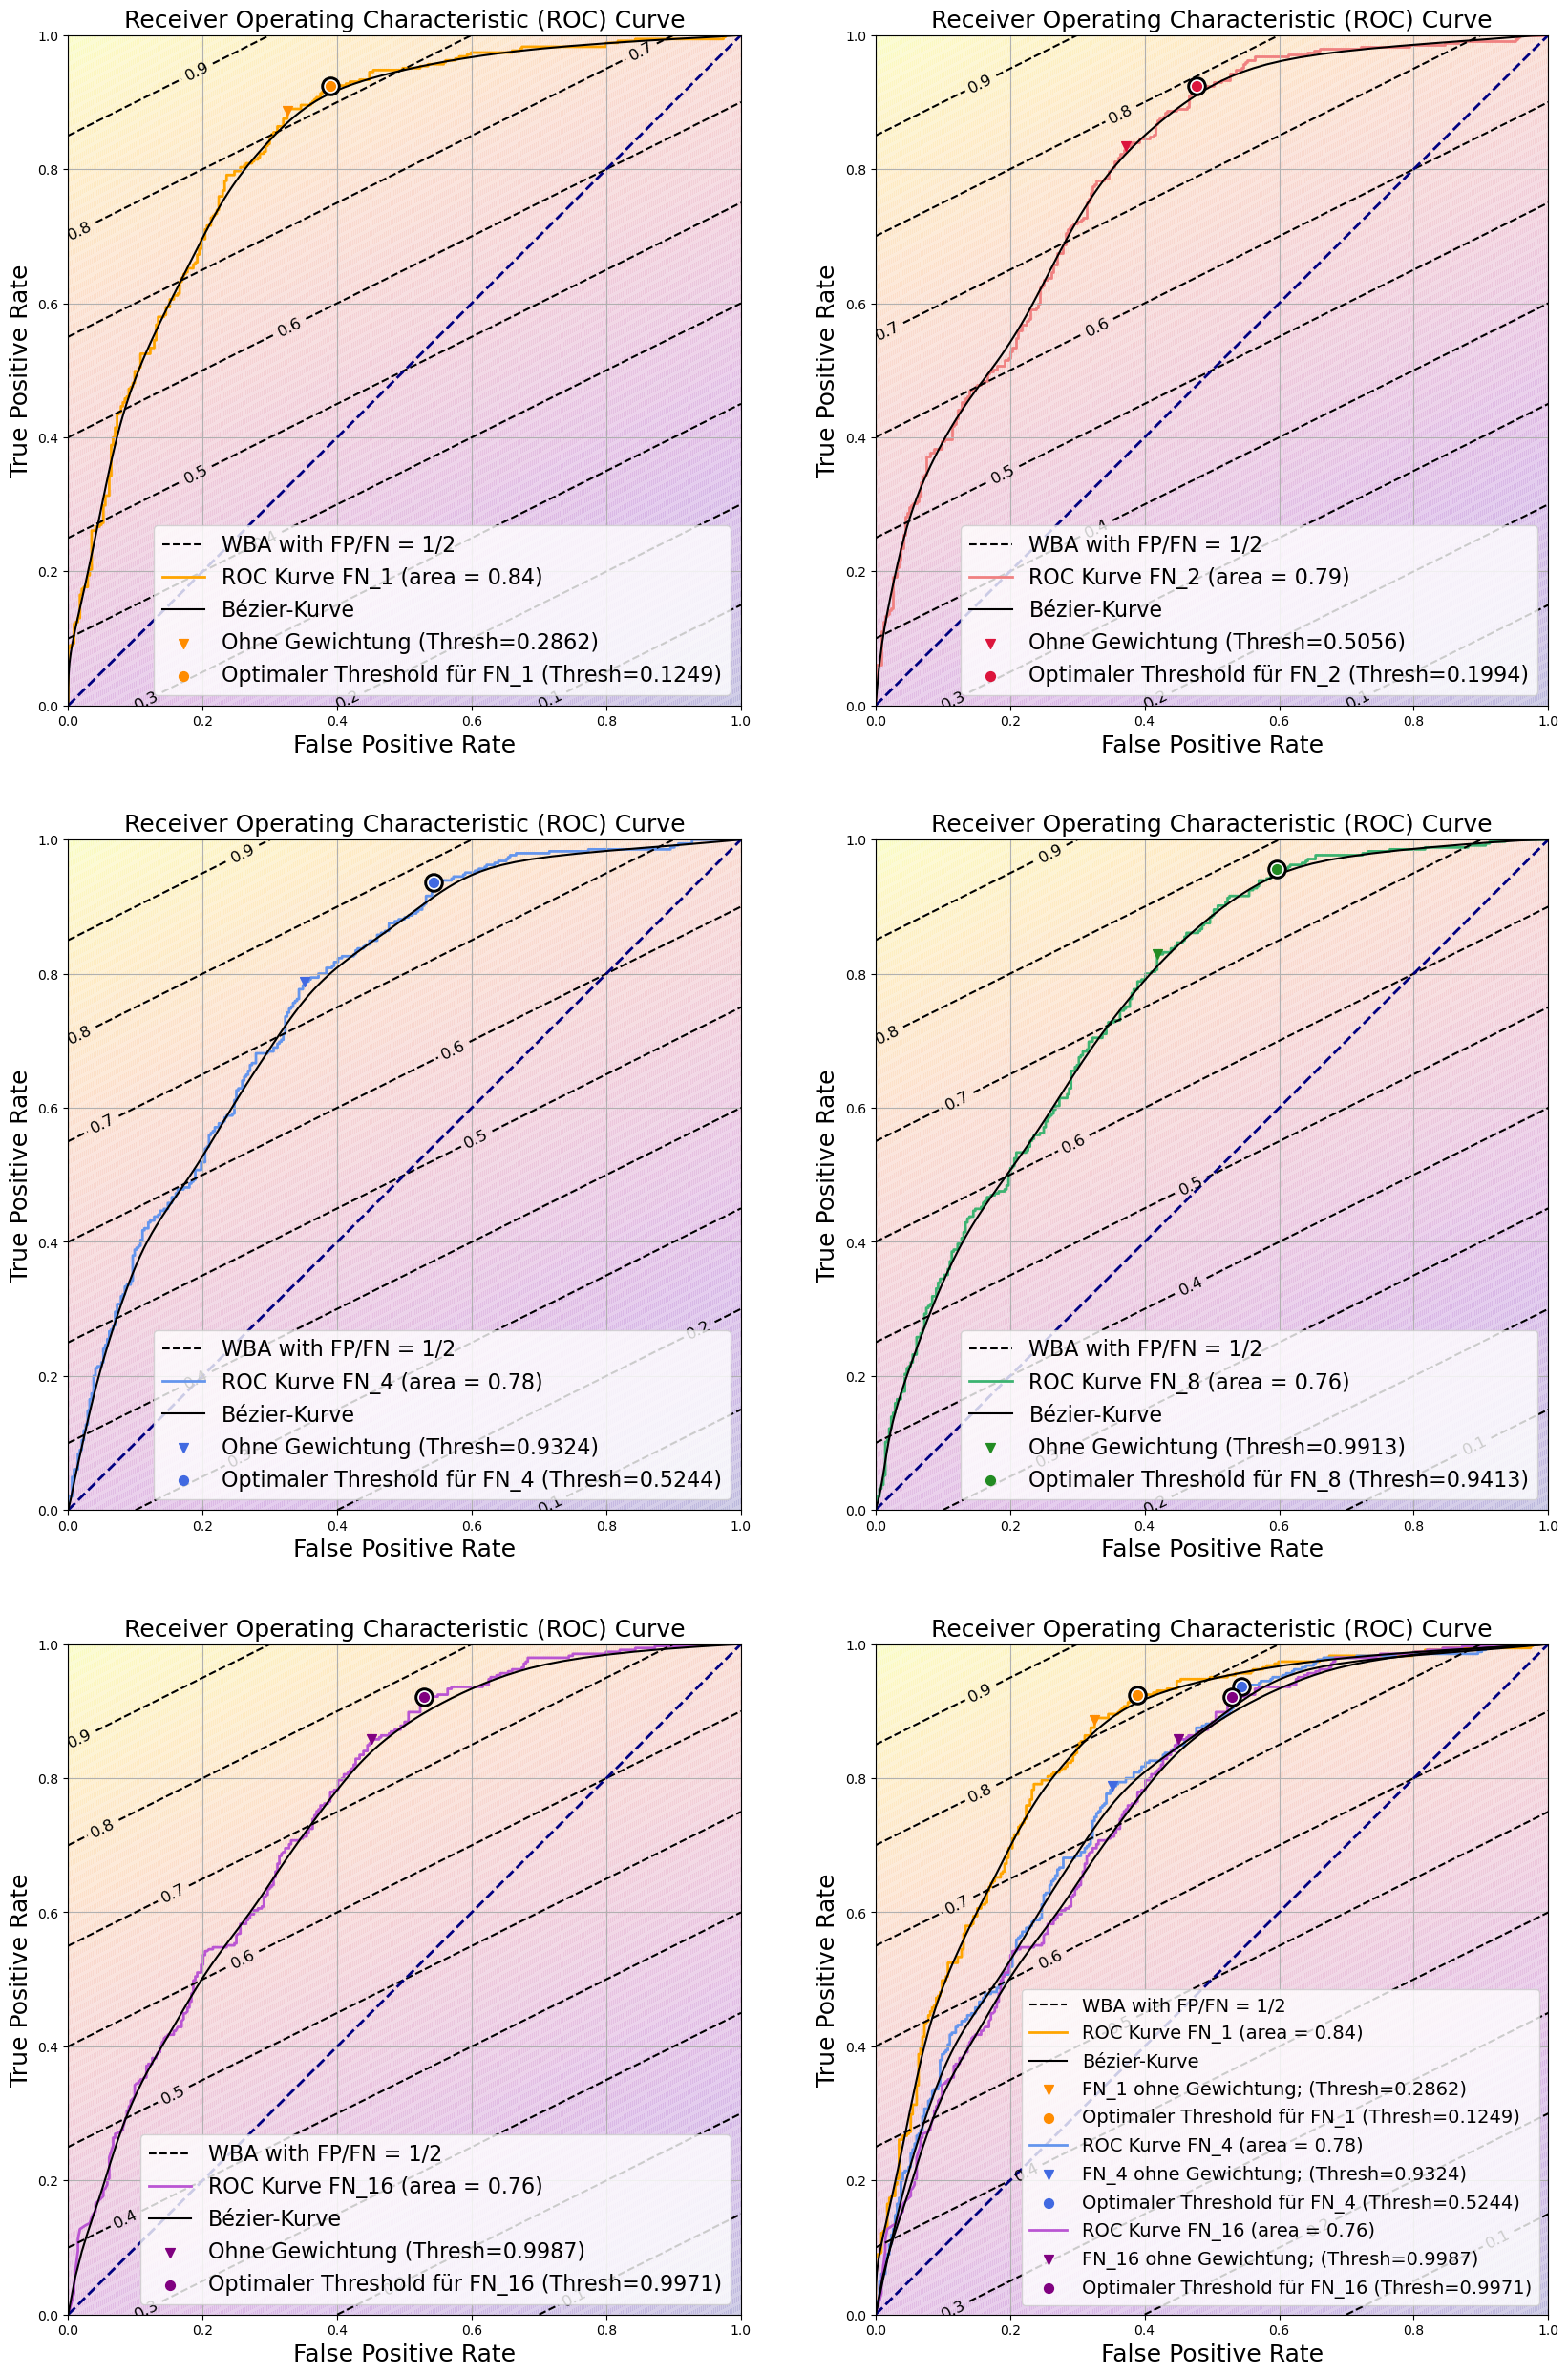

In [27]:
w_TP_wba = 1/3
w_TN_wba = 2/3
fig, sub = plt.subplots(3, 2, figsize=(20, 31))
roc_with_wba(fpr_FN_1, tpr_FN_1, auc_FN_1, w_TP_wba, w_TN_wba, 
             FN_1_fpr_ER_min[0], FN_1_tpr_ER_min[0], FN_1_ER_thresh_all[0], 
             FN_1_fpr_ER_min[1], FN_1_tpr_ER_min[1], FN_1_ER_thresh_all[1], 
             wba_ratio=2, ax=sub[0,0], bezier=True, model_number=1, color_curve='orange', color_point='darkorange')

roc_with_wba(fpr_FN_2, tpr_FN_2, auc_FN_2, w_TP_wba, w_TN_wba, 
             FN_2_fpr_ER_min[0], FN_2_tpr_ER_min[0], FN_2_ER_thresh_all[0], 
             FN_2_fpr_ER_min[1], FN_2_tpr_ER_min[1], FN_2_ER_thresh_all[1], 
             wba_ratio=2, ax=sub[0,1], bezier=True, model_number=2, color_curve='lightcoral', color_point='crimson')

roc_with_wba(fpr_FN_4, tpr_FN_4, auc_FN_4, w_TP_wba, w_TN_wba, 
             FN_4_fpr_ER_min[0], FN_4_tpr_ER_min[0], FN_4_ER_thresh_all[0], 
             FN_4_fpr_ER_min[1], FN_4_tpr_ER_min[1], FN_4_ER_thresh_all[1], 
             wba_ratio=2, ax=sub[1,0], bezier=True, model_number=4, color_curve='cornflowerblue', color_point='royalblue')

roc_with_wba(fpr_FN_8, tpr_FN_8, auc_FN_8, w_TP_wba, w_TN_wba, 
             FN_8_fpr_ER_min[0], FN_8_tpr_ER_min[0], FN_8_ER_thresh_all[0], 
             FN_8_fpr_ER_min[1], FN_8_tpr_ER_min[1], FN_8_ER_thresh_all[1], 
             wba_ratio=2, ax=sub[1,1], bezier=True, model_number=8, color_curve='mediumseagreen', color_point='forestgreen')

roc_with_wba(fpr_FN_16, tpr_FN_16, auc_FN_16, w_TP_wba, w_TN_wba, 
             FN_16_fpr_ER_min[0], FN_16_tpr_ER_min[0], FN_16_ER_thresh_all[0], 
             FN_16_fpr_ER_min[1], FN_16_tpr_ER_min[1], FN_16_ER_thresh_all[1], 
             wba_ratio=2, ax=sub[2,0], bezier=True, model_number=16, color_curve='mediumorchid', color_point='purple')


# combined plot 1, 4, 16
fpr_FN_1_4 = [fpr_FN_1, fpr_FN_4, fpr_FN_16]
tpr_FN_1_4 = [tpr_FN_1, tpr_FN_4, tpr_FN_16]
auc_FN_1_4 = [auc_FN_1, auc_FN_4, auc_FN_16]
FN_1_4_fpr_ER_min_BA = [FN_1_fpr_ER_min[0], FN_4_fpr_ER_min[0], FN_16_fpr_ER_min[0]]
FN_1_4_tpr_ER_min_BA = [FN_1_tpr_ER_min[0],  FN_4_tpr_ER_min[0], FN_16_tpr_ER_min[0]]
FN_1_4_ER_thresh_all_BA = [FN_1_ER_thresh_all[0], FN_4_ER_thresh_all[0], FN_16_ER_thresh_all[0]]
FN_1_4_fpr_ER_min = [FN_1_fpr_ER_min[1], FN_4_fpr_ER_min[1], FN_16_fpr_ER_min[1]]
FN_1_4_tpr_ER_min = [FN_1_tpr_ER_min[1], FN_4_tpr_ER_min[1], FN_16_tpr_ER_min[1]]
FN_1_4_ER_thresh_all = [FN_1_ER_thresh_all[1], FN_4_ER_thresh_all[1], FN_16_ER_thresh_all[1]]
model_numbers = [1,4,16]


roc_with_wba_multipe(fpr_FN_1_4, tpr_FN_1_4, auc_FN_1_4, w_TP_wba, w_TN_wba, 
             FN_1_4_fpr_ER_min_BA, FN_1_4_tpr_ER_min_BA, FN_1_4_ER_thresh_all_BA, 
             FN_1_4_fpr_ER_min, FN_1_4_tpr_ER_min, FN_1_4_ER_thresh_all, 
             wba_ratio=2, ax=sub[2,1], model_number=model_numbers)


In [423]:
fig.savefig('comparison_wba_2')

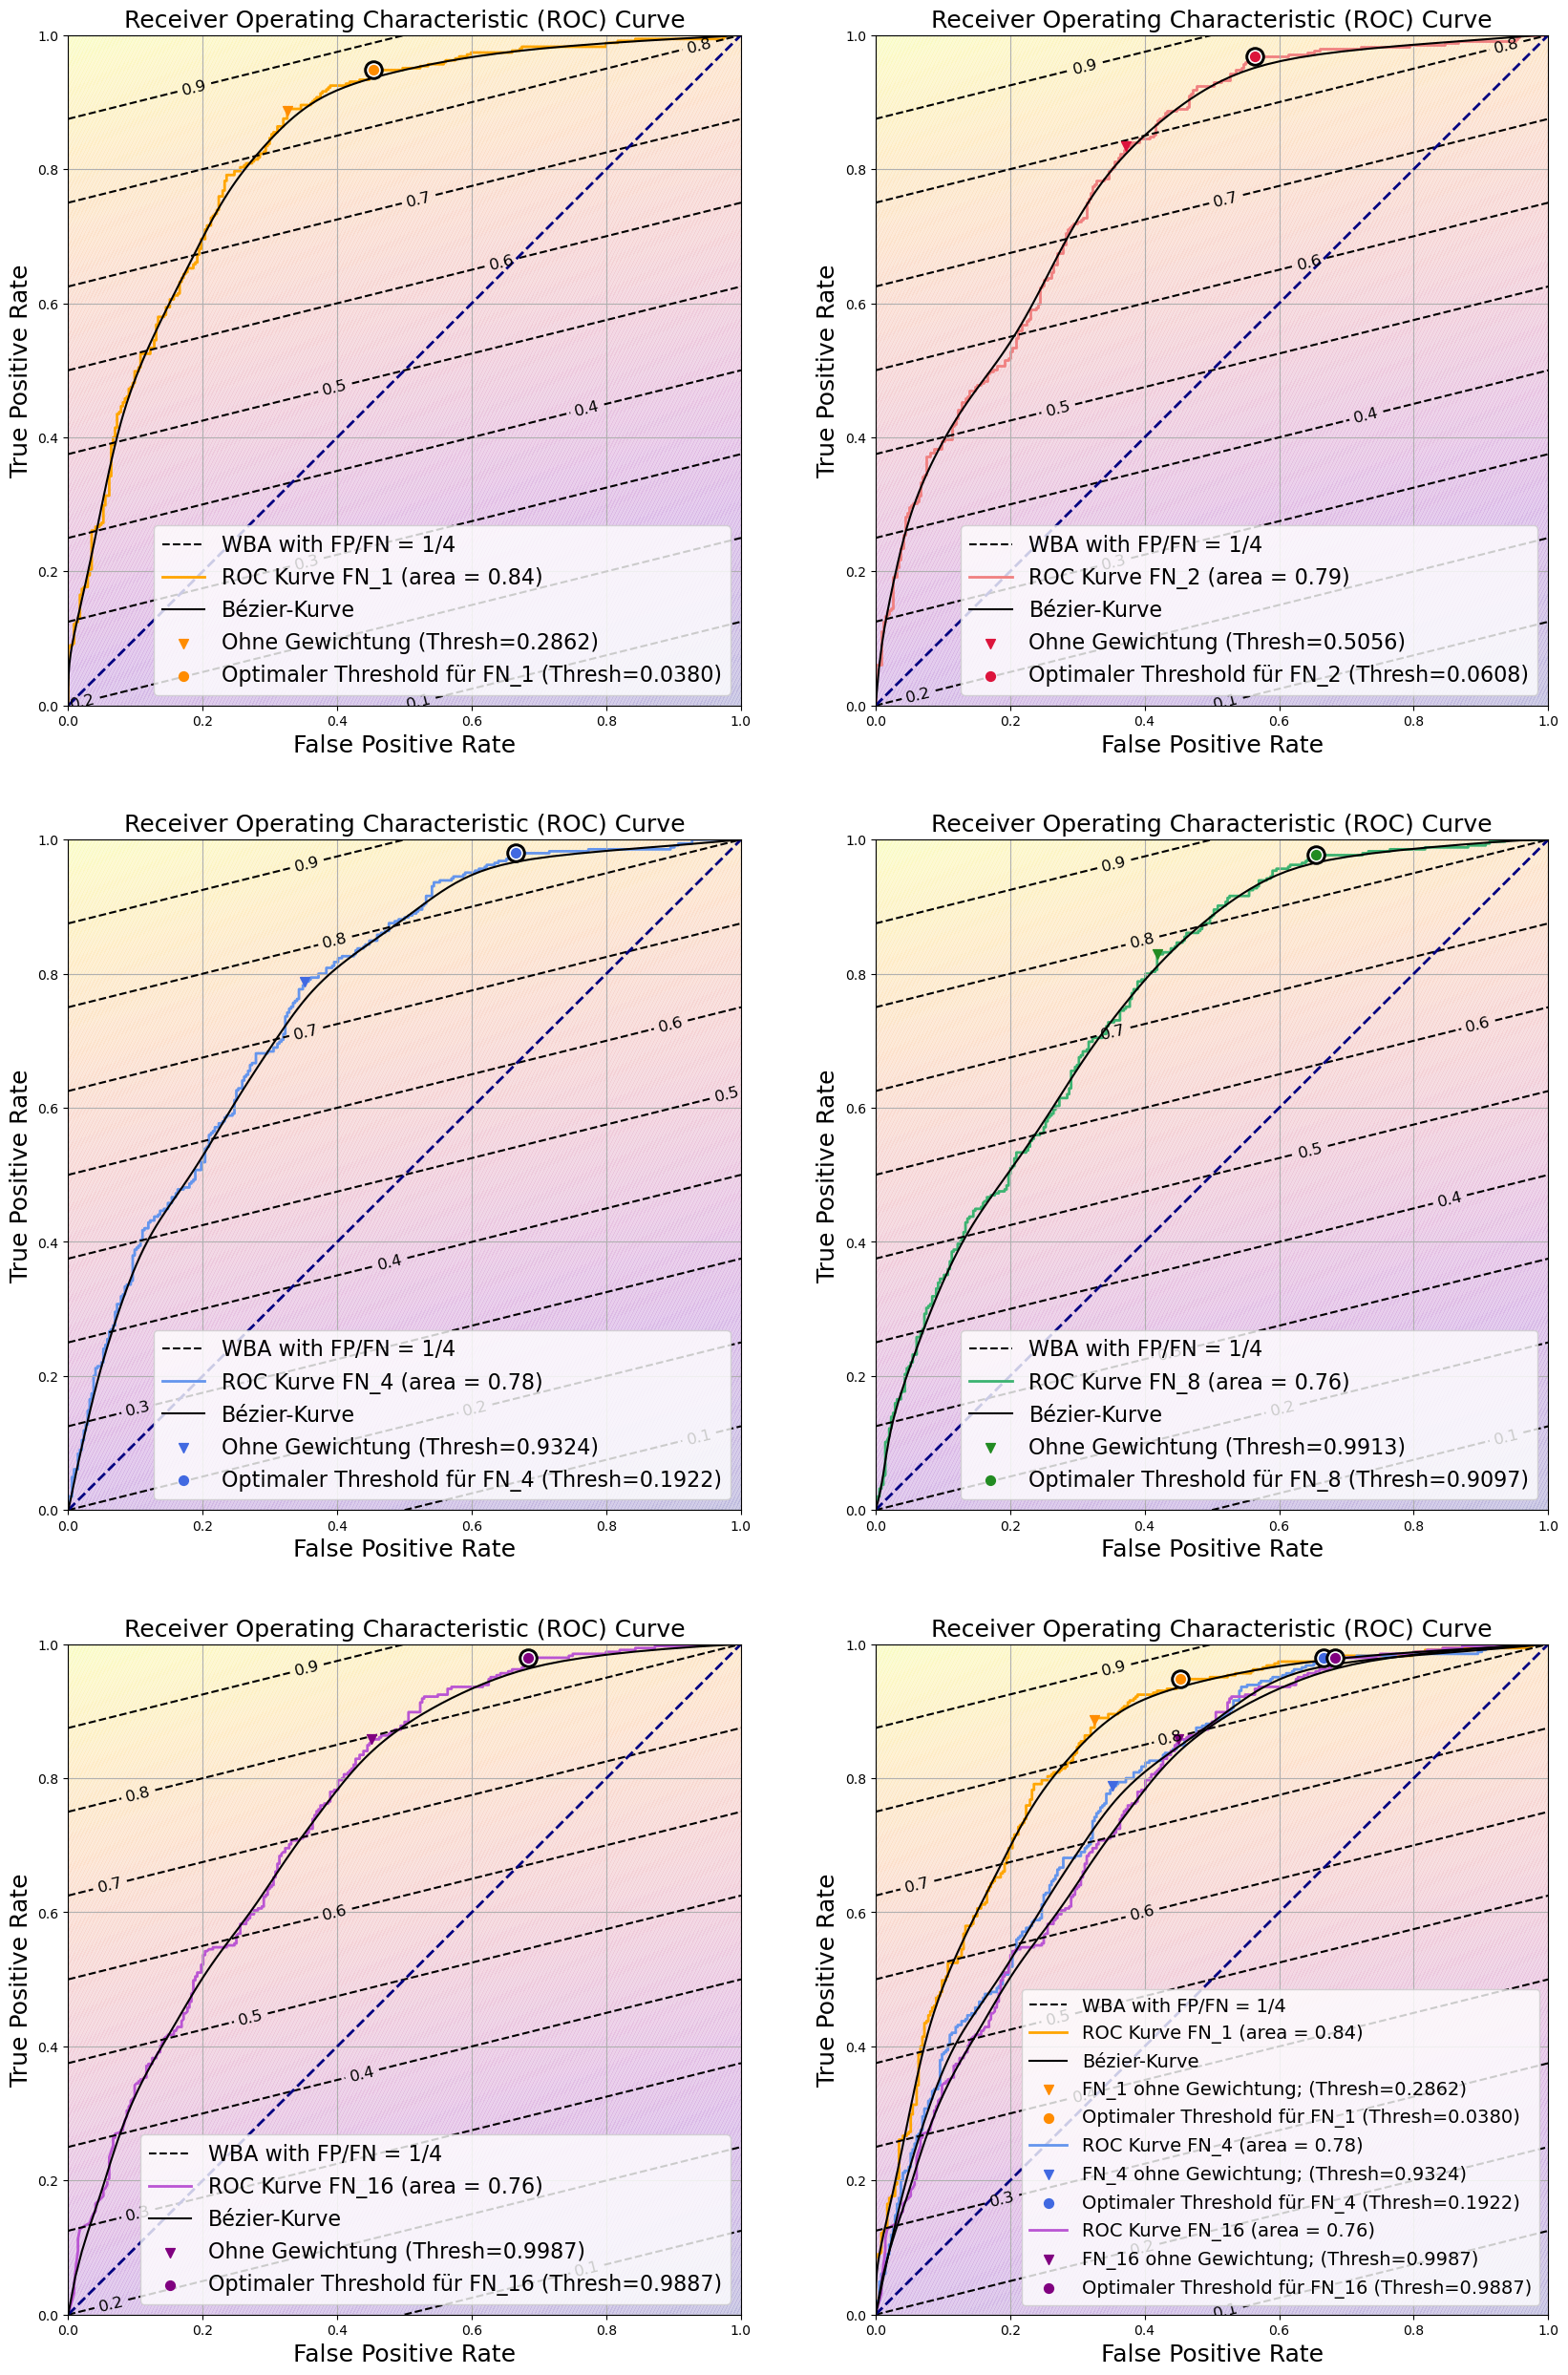

In [424]:
w_TP_wba = 1/5
w_TN_wba = 4/5
fig, sub = plt.subplots(3, 2, figsize=(20, 31))
roc_with_wba(fpr_FN_1, tpr_FN_1, auc_FN_1, w_TP_wba, w_TN_wba, 
             FN_1_fpr_ER_min[0], FN_1_tpr_ER_min[0], FN_1_ER_thresh_all[0], 
             FN_1_fpr_ER_min[2], FN_1_tpr_ER_min[2], FN_1_ER_thresh_all[2], #change
             wba_ratio=4, ax=sub[0,0], bezier=True, model_number=1, color_curve='orange', color_point='darkorange')

roc_with_wba(fpr_FN_2, tpr_FN_2, auc_FN_2, w_TP_wba, w_TN_wba, 
             FN_2_fpr_ER_min[0], FN_2_tpr_ER_min[0], FN_2_ER_thresh_all[0], 
             FN_2_fpr_ER_min[2], FN_2_tpr_ER_min[2], FN_2_ER_thresh_all[2], #change
             wba_ratio=4, ax=sub[0,1], bezier=True, model_number=2, color_curve='lightcoral', color_point='crimson')

roc_with_wba(fpr_FN_4, tpr_FN_4, auc_FN_4, w_TP_wba, w_TN_wba, 
             FN_4_fpr_ER_min[0], FN_4_tpr_ER_min[0], FN_4_ER_thresh_all[0], 
             FN_4_fpr_ER_min[2], FN_4_tpr_ER_min[2], FN_4_ER_thresh_all[2], #change
             wba_ratio=4, ax=sub[1,0], bezier=True, model_number=4, color_curve='cornflowerblue', color_point='royalblue')

roc_with_wba(fpr_FN_8, tpr_FN_8, auc_FN_8, w_TP_wba, w_TN_wba, 
             FN_8_fpr_ER_min[0], FN_8_tpr_ER_min[0], FN_8_ER_thresh_all[0], 
             FN_8_fpr_ER_min[2], FN_8_tpr_ER_min[2], FN_8_ER_thresh_all[2], #change
             wba_ratio=4, ax=sub[1,1], bezier=True, model_number=8, color_curve='mediumseagreen', color_point='forestgreen')

roc_with_wba(fpr_FN_16, tpr_FN_16, auc_FN_16, w_TP_wba, w_TN_wba, 
             FN_16_fpr_ER_min[0], FN_16_tpr_ER_min[0], FN_16_ER_thresh_all[0], 
             FN_16_fpr_ER_min[2], FN_16_tpr_ER_min[2], FN_16_ER_thresh_all[2], #change
             wba_ratio=4, ax=sub[2,0], bezier=True, model_number=16, color_curve='mediumorchid', color_point='purple')


# combined plot 1, 4, 16
fpr_FN_1_4 = [fpr_FN_1, fpr_FN_4, fpr_FN_16]
tpr_FN_1_4 = [tpr_FN_1, tpr_FN_4, tpr_FN_16]
auc_FN_1_4 = [auc_FN_1, auc_FN_4, auc_FN_16]
FN_1_4_fpr_ER_min_BA = [FN_1_fpr_ER_min[0], FN_4_fpr_ER_min[0], FN_16_fpr_ER_min[0]]
FN_1_4_tpr_ER_min_BA = [FN_1_tpr_ER_min[0],  FN_4_tpr_ER_min[0], FN_16_tpr_ER_min[0]]
FN_1_4_ER_thresh_all_BA = [FN_1_ER_thresh_all[0], FN_4_ER_thresh_all[0], FN_16_ER_thresh_all[0]]
FN_1_4_fpr_ER_min = [FN_1_fpr_ER_min[2], FN_4_fpr_ER_min[2], FN_16_fpr_ER_min[2]] #change
FN_1_4_tpr_ER_min = [FN_1_tpr_ER_min[2], FN_4_tpr_ER_min[2], FN_16_tpr_ER_min[2]] #change
FN_1_4_ER_thresh_all = [FN_1_ER_thresh_all[2], FN_4_ER_thresh_all[2], FN_16_ER_thresh_all[2]] #change
model_numbers = [1,4,16]


roc_with_wba_multipe(fpr_FN_1_4, tpr_FN_1_4, auc_FN_1_4, w_TP_wba, w_TN_wba, 
             FN_1_4_fpr_ER_min_BA, FN_1_4_tpr_ER_min_BA, FN_1_4_ER_thresh_all_BA, 
             FN_1_4_fpr_ER_min, FN_1_4_tpr_ER_min, FN_1_4_ER_thresh_all, 
             wba_ratio=4, ax=sub[2,1], model_number=model_numbers)


In [425]:
fig.savefig('comparison_wba_4')

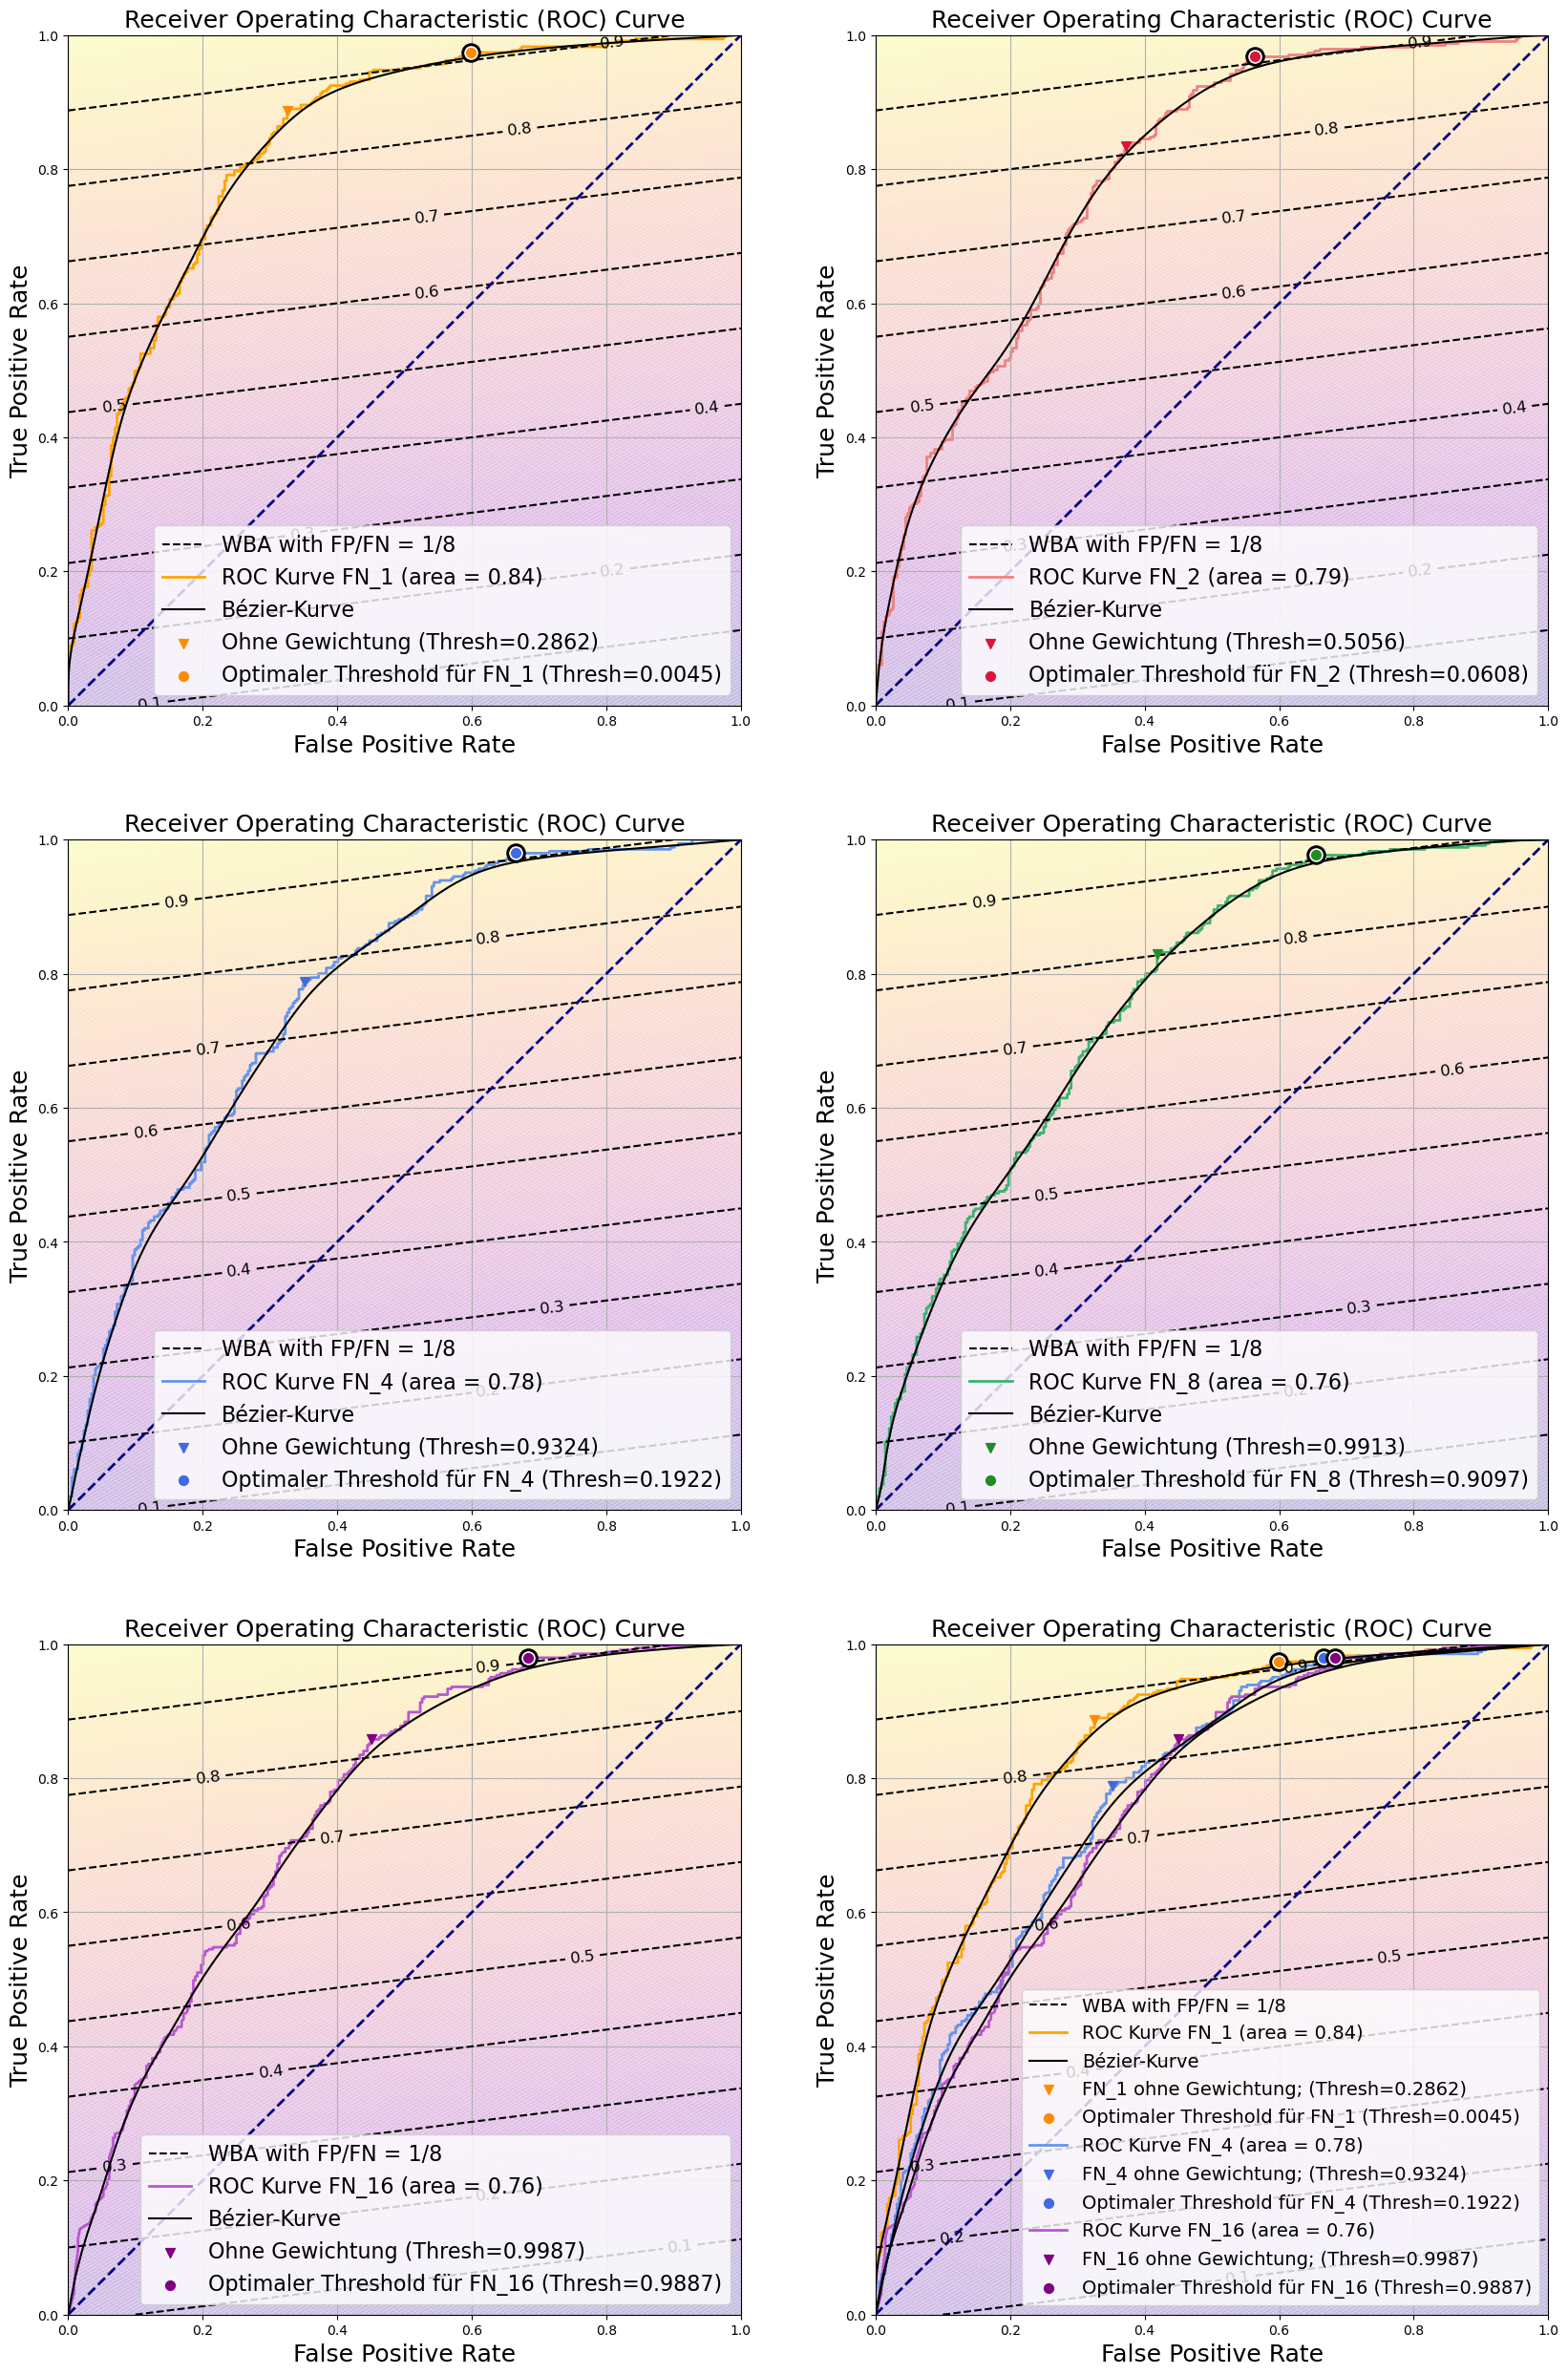

In [426]:
w_TP_wba = 1/9 #change
w_TN_wba = 8/9 #change
fig, sub = plt.subplots(3, 2, figsize=(20, 31))
roc_with_wba(fpr_FN_1, tpr_FN_1, auc_FN_1, w_TP_wba, w_TN_wba, 
             FN_1_fpr_ER_min[0], FN_1_tpr_ER_min[0], FN_1_ER_thresh_all[0], 
             FN_1_fpr_ER_min[3], FN_1_tpr_ER_min[3], FN_1_ER_thresh_all[3], #change
             wba_ratio=8, ax=sub[0,0], bezier=True, model_number=1, color_curve='orange', color_point='darkorange') #change

roc_with_wba(fpr_FN_2, tpr_FN_2, auc_FN_2, w_TP_wba, w_TN_wba, 
             FN_2_fpr_ER_min[0], FN_2_tpr_ER_min[0], FN_2_ER_thresh_all[0], 
             FN_2_fpr_ER_min[3], FN_2_tpr_ER_min[3], FN_2_ER_thresh_all[3], #change
             wba_ratio=8, ax=sub[0,1], bezier=True, model_number=2, color_curve='lightcoral', color_point='crimson')#change

roc_with_wba(fpr_FN_4, tpr_FN_4, auc_FN_4, w_TP_wba, w_TN_wba, 
             FN_4_fpr_ER_min[0], FN_4_tpr_ER_min[0], FN_4_ER_thresh_all[0], 
             FN_4_fpr_ER_min[3], FN_4_tpr_ER_min[3], FN_4_ER_thresh_all[3], #change
             wba_ratio=8, ax=sub[1,0], bezier=True, model_number=4, color_curve='cornflowerblue', color_point='royalblue')#change

roc_with_wba(fpr_FN_8, tpr_FN_8, auc_FN_8, w_TP_wba, w_TN_wba, 
             FN_8_fpr_ER_min[0], FN_8_tpr_ER_min[0], FN_8_ER_thresh_all[0], 
             FN_8_fpr_ER_min[3], FN_8_tpr_ER_min[3], FN_8_ER_thresh_all[3], #change
             wba_ratio=8, ax=sub[1,1], bezier=True, model_number=8, color_curve='mediumseagreen', color_point='forestgreen')#change

roc_with_wba(fpr_FN_16, tpr_FN_16, auc_FN_16, w_TP_wba, w_TN_wba, 
             FN_16_fpr_ER_min[0], FN_16_tpr_ER_min[0], FN_16_ER_thresh_all[0], 
             FN_16_fpr_ER_min[3], FN_16_tpr_ER_min[3], FN_16_ER_thresh_all[3], #change
             wba_ratio=8, ax=sub[2,0], bezier=True, model_number=16, color_curve='mediumorchid', color_point='purple')#change


# combined plot 1, 4, 16
fpr_FN_1_4 = [fpr_FN_1, fpr_FN_4, fpr_FN_16]
tpr_FN_1_4 = [tpr_FN_1, tpr_FN_4, tpr_FN_16]
auc_FN_1_4 = [auc_FN_1, auc_FN_4, auc_FN_16]
FN_1_4_fpr_ER_min_BA = [FN_1_fpr_ER_min[0], FN_4_fpr_ER_min[0], FN_16_fpr_ER_min[0]]
FN_1_4_tpr_ER_min_BA = [FN_1_tpr_ER_min[0],  FN_4_tpr_ER_min[0], FN_16_tpr_ER_min[0]]
FN_1_4_ER_thresh_all_BA = [FN_1_ER_thresh_all[0], FN_4_ER_thresh_all[0], FN_16_ER_thresh_all[0]]
FN_1_4_fpr_ER_min = [FN_1_fpr_ER_min[3], FN_4_fpr_ER_min[3], FN_16_fpr_ER_min[3]] #change
FN_1_4_tpr_ER_min = [FN_1_tpr_ER_min[3], FN_4_tpr_ER_min[3], FN_16_tpr_ER_min[3]] #change
FN_1_4_ER_thresh_all = [FN_1_ER_thresh_all[3], FN_4_ER_thresh_all[3], FN_16_ER_thresh_all[3]] #change
model_numbers = [1,4,16]


roc_with_wba_multipe(fpr_FN_1_4, tpr_FN_1_4, auc_FN_1_4, w_TP_wba, w_TN_wba, 
             FN_1_4_fpr_ER_min_BA, FN_1_4_tpr_ER_min_BA, FN_1_4_ER_thresh_all_BA, 
             FN_1_4_fpr_ER_min, FN_1_4_tpr_ER_min, FN_1_4_ER_thresh_all, 
             wba_ratio=8, ax=sub[2,1], model_number=model_numbers)


In [427]:
fig.savefig('comparison_wba_8')

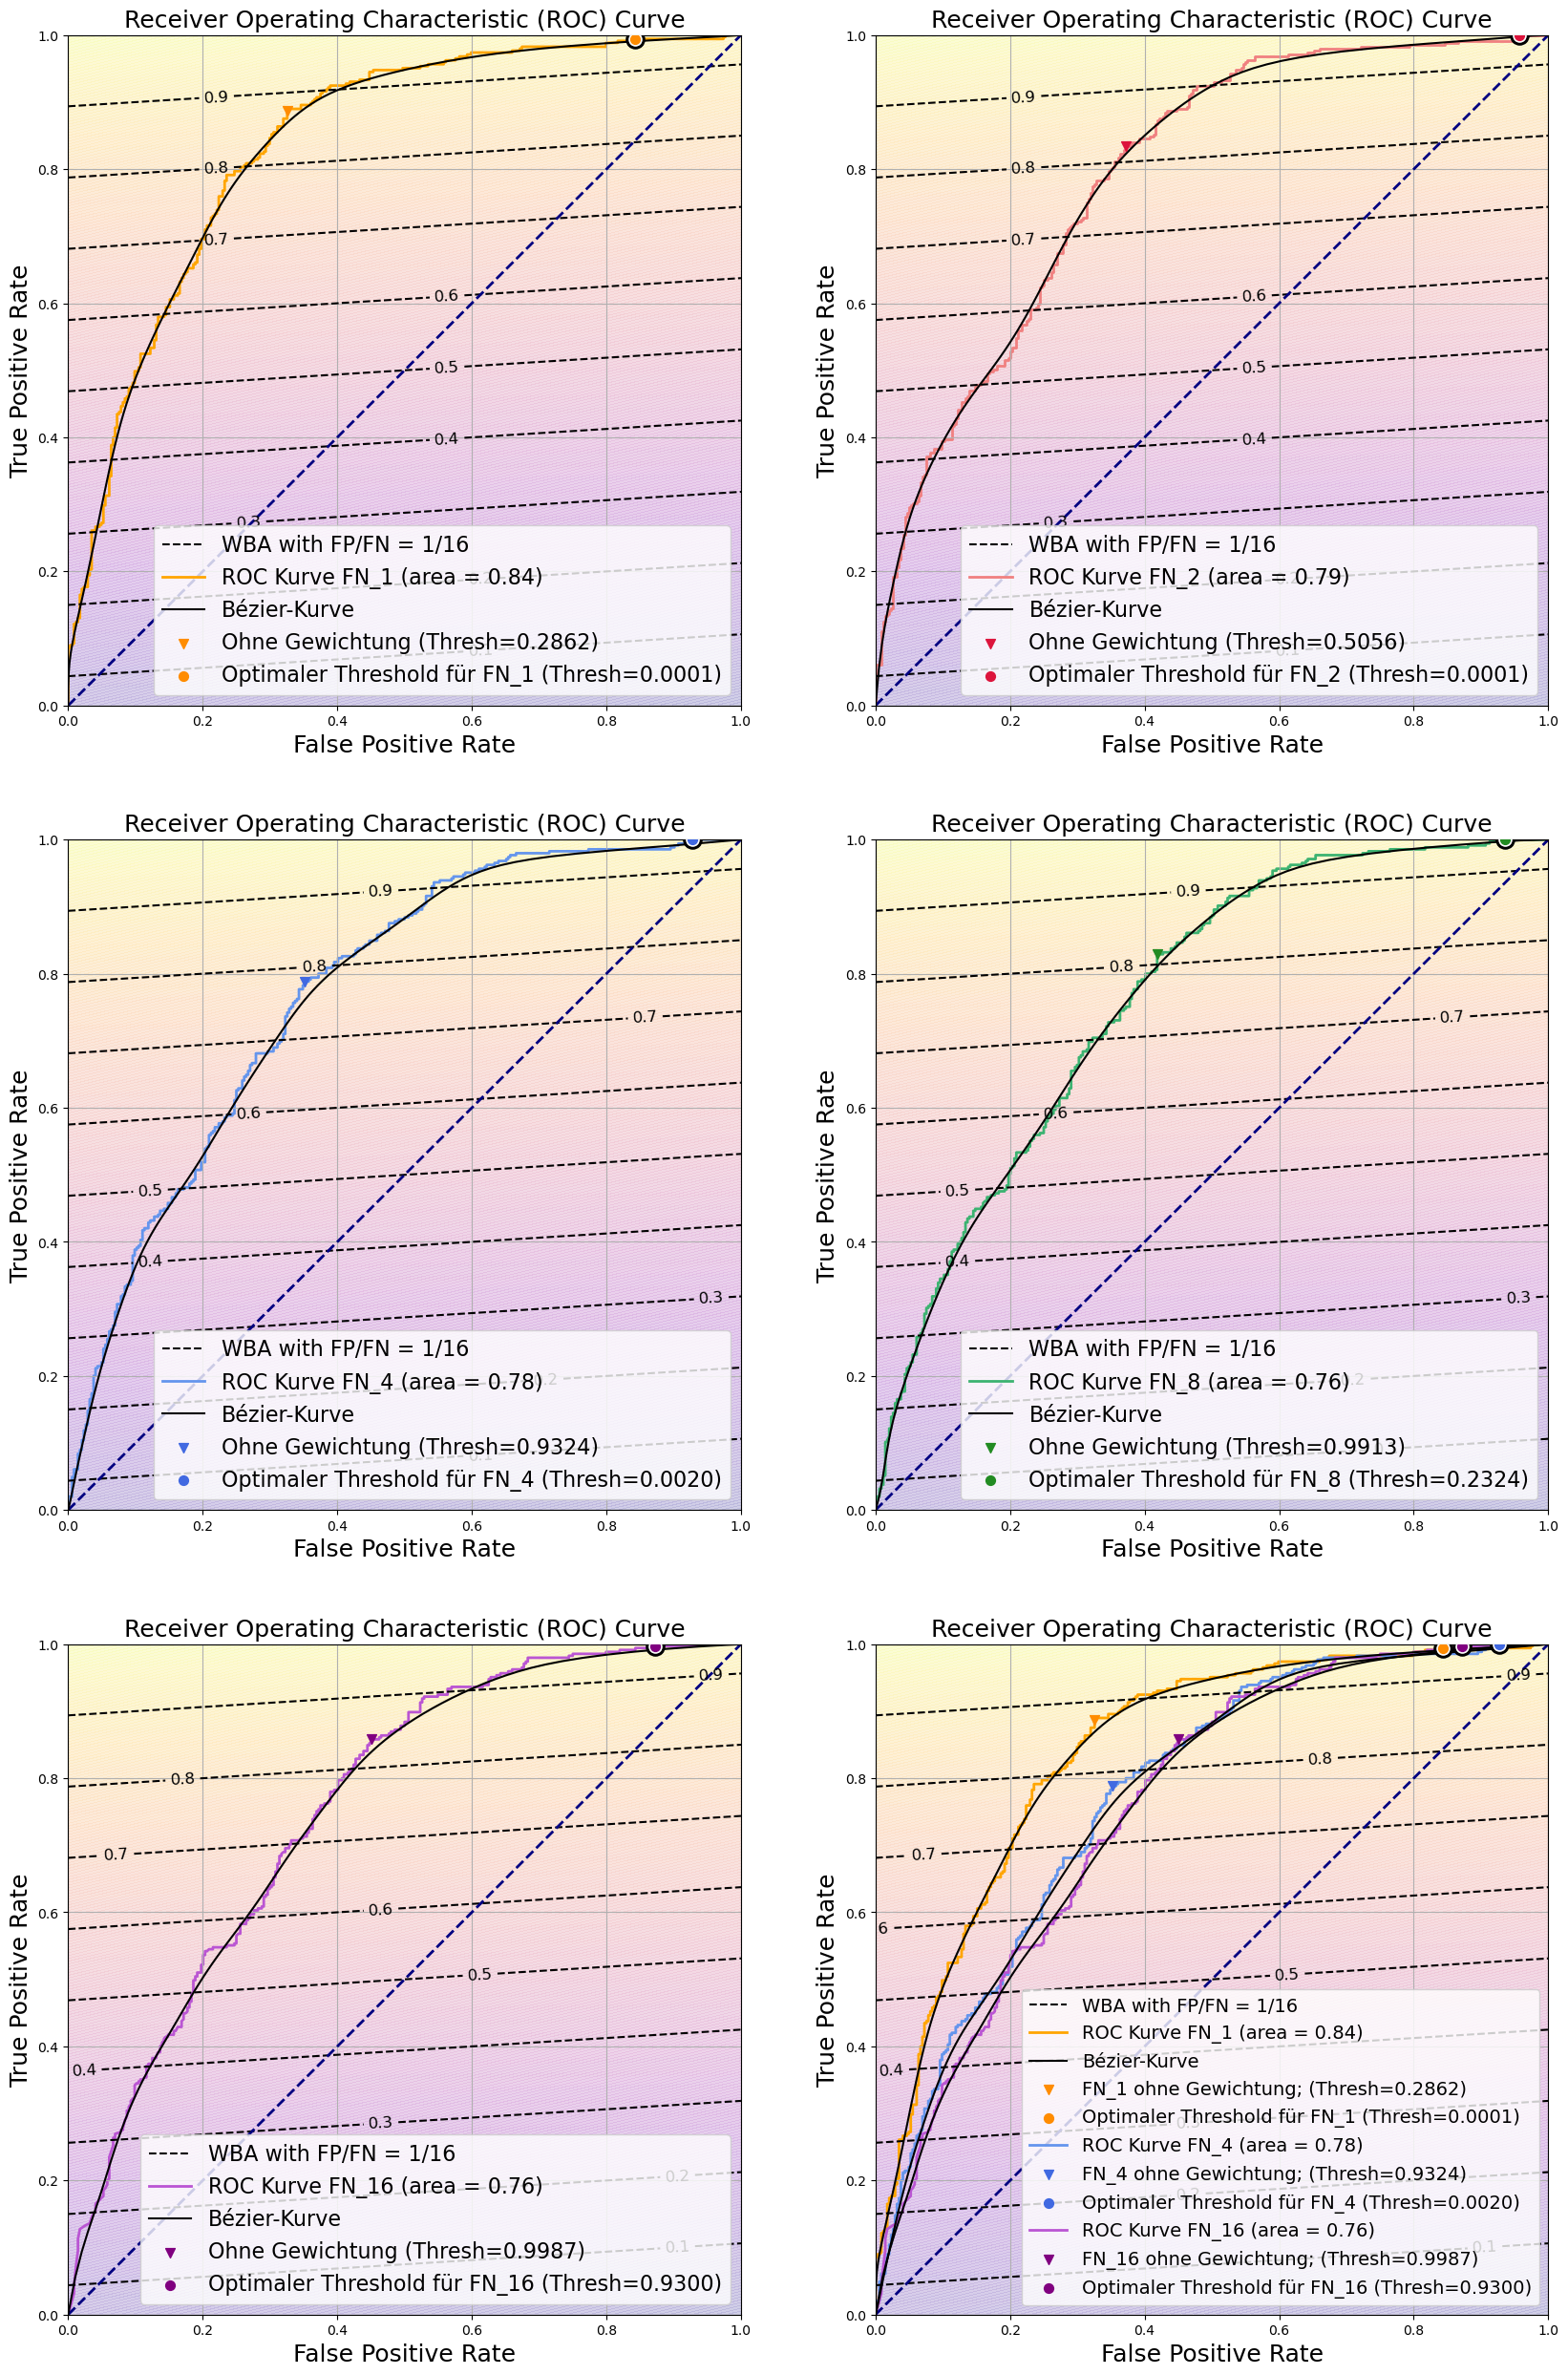

In [428]:
w_TP_wba = 1/17 #change
w_TN_wba = 16/17 #change
fig, sub = plt.subplots(3, 2, figsize=(20, 31))
roc_with_wba(fpr_FN_1, tpr_FN_1, auc_FN_1, w_TP_wba, w_TN_wba, 
             FN_1_fpr_ER_min[0], FN_1_tpr_ER_min[0], FN_1_ER_thresh_all[0], 
             FN_1_fpr_ER_min[4], FN_1_tpr_ER_min[4], FN_1_ER_thresh_all[4], #change
             wba_ratio=16, ax=sub[0,0], bezier=True, model_number=1, color_curve='orange', color_point='darkorange')

roc_with_wba(fpr_FN_2, tpr_FN_2, auc_FN_2, w_TP_wba, w_TN_wba, 
             FN_2_fpr_ER_min[0], FN_2_tpr_ER_min[0], FN_2_ER_thresh_all[0], 
             FN_2_fpr_ER_min[4], FN_2_tpr_ER_min[4], FN_2_ER_thresh_all[4], #change
             wba_ratio=16, ax=sub[0,1], bezier=True, model_number=2, color_curve='lightcoral', color_point='crimson')

roc_with_wba(fpr_FN_4, tpr_FN_4, auc_FN_4, w_TP_wba, w_TN_wba, 
             FN_4_fpr_ER_min[0], FN_4_tpr_ER_min[0], FN_4_ER_thresh_all[0], 
             FN_4_fpr_ER_min[4], FN_4_tpr_ER_min[4], FN_4_ER_thresh_all[4], #change
             wba_ratio=16, ax=sub[1,0], bezier=True, model_number=4, color_curve='cornflowerblue', color_point='royalblue')

roc_with_wba(fpr_FN_8, tpr_FN_8, auc_FN_8, w_TP_wba, w_TN_wba, 
             FN_8_fpr_ER_min[0], FN_8_tpr_ER_min[0], FN_8_ER_thresh_all[0], 
             FN_8_fpr_ER_min[4], FN_8_tpr_ER_min[4], FN_8_ER_thresh_all[4], #change
             wba_ratio=16, ax=sub[1,1], bezier=True, model_number=8, color_curve='mediumseagreen', color_point='forestgreen')

roc_with_wba(fpr_FN_16, tpr_FN_16, auc_FN_16, w_TP_wba, w_TN_wba, 
             FN_16_fpr_ER_min[0], FN_16_tpr_ER_min[0], FN_16_ER_thresh_all[0], 
             FN_16_fpr_ER_min[4], FN_16_tpr_ER_min[4], FN_16_ER_thresh_all[4], #change
             wba_ratio=16, ax=sub[2,0], bezier=True, model_number=16, color_curve='mediumorchid', color_point='purple')


# combined plot 1, 4, 16
fpr_FN_1_4 = [fpr_FN_1, fpr_FN_4, fpr_FN_16]
tpr_FN_1_4 = [tpr_FN_1, tpr_FN_4, tpr_FN_16]
auc_FN_1_4 = [auc_FN_1, auc_FN_4, auc_FN_16]
FN_1_4_fpr_ER_min_BA = [FN_1_fpr_ER_min[0], FN_4_fpr_ER_min[0], FN_16_fpr_ER_min[0]]
FN_1_4_tpr_ER_min_BA = [FN_1_tpr_ER_min[0],  FN_4_tpr_ER_min[0], FN_16_tpr_ER_min[0]]
FN_1_4_ER_thresh_all_BA = [FN_1_ER_thresh_all[0], FN_4_ER_thresh_all[0], FN_16_ER_thresh_all[0]]
FN_1_4_fpr_ER_min = [FN_1_fpr_ER_min[4], FN_4_fpr_ER_min[4], FN_16_fpr_ER_min[4]] #change
FN_1_4_tpr_ER_min = [FN_1_tpr_ER_min[4], FN_4_tpr_ER_min[4], FN_16_tpr_ER_min[4]] #change
FN_1_4_ER_thresh_all = [FN_1_ER_thresh_all[4], FN_4_ER_thresh_all[4], FN_16_ER_thresh_all[4]] #change
model_numbers = [1,4,16]


roc_with_wba_multipe(fpr_FN_1_4, tpr_FN_1_4, auc_FN_1_4, w_TP_wba, w_TN_wba, 
             FN_1_4_fpr_ER_min_BA, FN_1_4_tpr_ER_min_BA, FN_1_4_ER_thresh_all_BA, 
             FN_1_4_fpr_ER_min, FN_1_4_tpr_ER_min, FN_1_4_ER_thresh_all, 
             wba_ratio=16, ax=sub[2,1], model_number=model_numbers) #change


In [429]:
fig.savefig('comparison_wba_16')

### saving models 19.09.

In [63]:
#model_FN_1.save('../model_FN_1.h5')
#model_FN_2.save('../models/model_FN_2.h5')
#model_FN_4.save('../models/model_FN_4.h5')
#model_FN_8.save('../models/model_FN_8.h5')
#model_FN_16.save('../models/model_FN_16.h5')